In [1]:
import scanpy as sc
import anndata as ann
import numpy as np 
import seaborn as sb
import pandas as pd
import pickle
from sklearn import preprocessing as pp
import diffxpy.api as de
import time
from scipy import sparse

import sys  
sys.path.insert(0, '/mnt/znas/icb_zstore01/groups/ml01/workspace/k.noerenberg/code/diabetes_analysis/')
from importlib import reload  
import helper
reload(helper)
import helper as h
import neighbours 
reload(neighbours )
import neighbours as snn
import expected_multiplet_rate as emr
reload(emr)
import expected_multiplet_rate as emr
#sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri
from rpy2.rinterface_lib import na_values as r_na

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
import neighbours 
reload(neighbours )
import neighbours as snn

In [3]:
%%R
library(scran)
library(biomaRt)
library(BiocParallel)
#library(Seurat)

In [4]:
# Path for saving results - last shared folder by all datasets
shared_folder='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/'
UID2='spikein_drug_annotation'

Load data:

In [5]:
#Load data
#adata=pickle.load(  open( shared_folder+"data_normalised.pkl", "rb" ) )
adata=h.open_h5ad(shared_folder+"data_normalised.h5ad",unique_id2=UID2)

## Add previously generated annotation

In [6]:
# Add previously generated annotation 
#adata_preannotated=h.open_h5ad("/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/maren/data_endo_final.h5ad",unique_id2=UID2)
preannotated=pd.read_table("/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/preannotated/GSE142465_MouseLTI_CellAnnotation_final.tsv",index_col=0)

In [7]:
preannotated.columns

Index(['nGene', 'nUMI', 'orig.ident', 'sample', 'percent.mito', 'res.0.5',
       'ClusterNames_0.5', 'tSNE_1', 'tSNE_2', 'celltype', 'spikeIn',
       'replicate', 'treatment', 'PredictedCell', 'PredictionConf',
       'PredictionMax', 'celltype2', 'nGene.peak', 'nGene.doublet', 'Ins2',
       'Gcg'],
      dtype='object')

In [8]:
preannotated.iloc[0,:]

nGene                         2866
nUMI                         16716
orig.ident                       X
sample              mIslets_I_DMSO
percent.mito             0.0261633
res.0.5                          0
ClusterNames_0.5                 0
tSNE_1                    -5.62799
tSNE_2                     11.7134
celltype                      Beta
spikeIn                        NaN
replicate                        I
treatment                     DMSO
PredictedCell                 Beta
PredictionConf             189.974
PredictionMax             0.981856
celltype2                     Beta
nGene.peak                 2746.14
nGene.doublet                 Keep
Ins2                       12.8198
Gcg                              0
Name: AAACCTGAGAAAGTGG-3, dtype: object

In [7]:
# Load metadata for the project
sample_dict=pd.read_excel('/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='spikein_drug',index_col='metadata')['sample_name'].to_dict()

In [8]:
# Reindex previous info df
preannotated.index=[idx.split('-')[0]+'-1-'+sample_dict[preannotated.at[idx,'sample']] for idx in preannotated.index]
preannotated=preannotated.reindex( adata.obs.index)

In [9]:
# Add pre-prepared cell type annotation to currently used dataset
# Add 'pre_' before each original annotation
for annotation in ['celltype','PredictedCell','celltype2']:
    annotation_new='pre_'+annotation
    # Data was sorted before - remove index as they do not match
    adata.obs[annotation_new]=pd.Series(preannotated[annotation].values,dtype='category').values
    # Replace np.nan with na
    adata.obs[annotation_new] = adata.obs[annotation_new].cat.add_categories('NA')
    adata.obs[annotation_new].fillna('NA', inplace =True) 
    # Remove unused categories
    adata.obs[annotation_new].cat.remove_unused_categories(inplace=True)

Pre-annotated cell type count

In [12]:
# Count of cells per annotation
for annotation in ['celltype','PredictedCell','celltype2']:
    # For some reason the same line above does not remove all categories, thus it is done here again
    adata.obs['pre_'+annotation].cat.remove_unused_categories(inplace=True)
    print('pre_'+annotation,':')
    print(adata.obs['pre_'+annotation].value_counts())

pre_celltype :
Beta            14781
3                3583
Alpha            3452
4                3326
Endocrine        2685
Gamma            1463
SI_Human         1087
Acinar            794
Endothelial1      785
10                762
Delta             624
11                355
Endothelial2      352
13                336
SI_Mouse          325
NA                 97
Name: pre_celltype, dtype: int64
pre_PredictedCell :
Beta      18817
Alpha      4752
Delta      3447
Gamma      2876
Acinar     2797
11         2021
NA           97
Name: pre_PredictedCell, dtype: int64
pre_celltype2 :
Beta            15966
Alpha            3907
3                3583
4                3326
Gamma            2271
SI_Human         1087
Acinar            847
Endothelial1      785
Delta             780
10                762
11                383
Endothelial2      352
13                336
SI_Mouse          325
NA                 97
Name: pre_celltype2, dtype: int64


In [11]:
# Set one annotation column to pre_cell_type to enable below code to work
adata.obs.rename(columns={'pre_celltype':'pre_cell_type'}, inplace=True)

## Visualisation

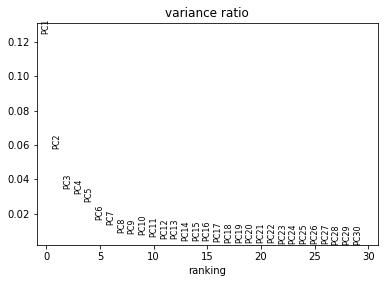

In [14]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [ ]:
# Select number of PCs to use
N_PCS=13

Compare different embeddings based on previously defined annotation. 

In [16]:
#sc.pp.neighbors(adata,n_pcs = N_PCS,metric='correlation') 
#sc.tl.umap(adata)

In [17]:
#rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
#sc.pl.umap(adata,size=10,color=['file'])

In [18]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

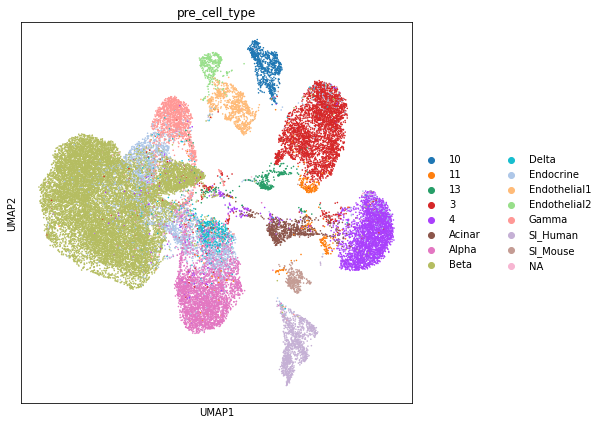

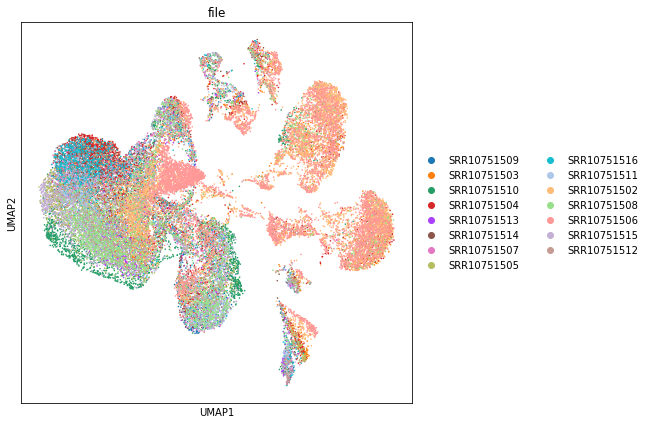

In [19]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata,size=10,color=['pre_cell_type'])
sc.pl.umap(adata,size=10,color=['file'])

#### On scaled data

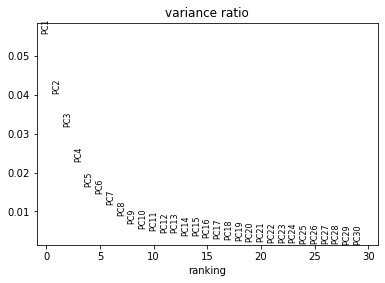

In [12]:
# Scale data and perform PCA
adata_scl=adata.copy()
sc.pp.scale(adata_scl,max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_scl)

In [21]:
#C: Can not stay the same as above
N_PCS

13

In [13]:
# neighbours on scaled data
sc.pp.neighbors(adata_scl,n_pcs = 18) 

In [14]:
# Umap on scaled data
sc.tl.umap(adata_scl)

In [15]:
# Add scaled embedding to adata
adata.obsm['X_umap_scl']=adata_scl.obsm['X_umap']

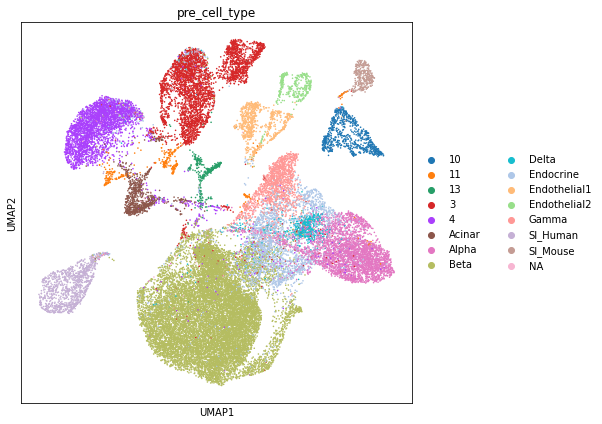

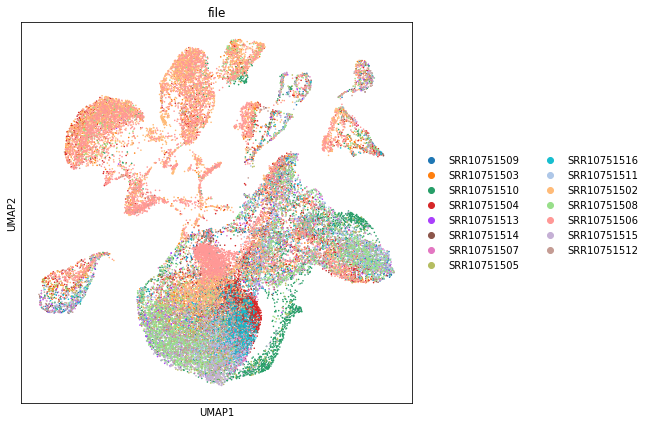

In [25]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_scl,size=10,color=['pre_cell_type'])
sc.pl.umap(adata_scl,size=10,color=['file'])

## Remove spike-in cell clusters

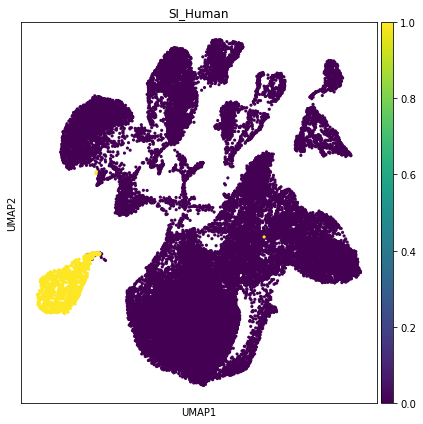

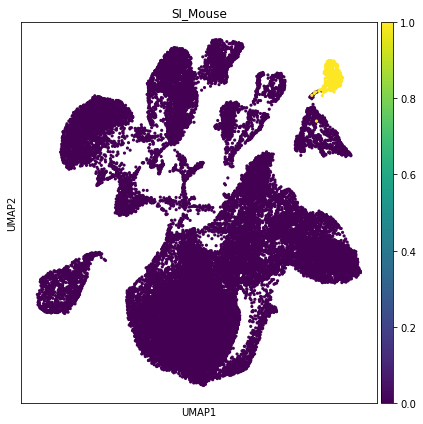

In [26]:
for si in ['SI_Human','SI_Mouse']:
    s=40
    adata_scl.obs['temp']=adata_scl.obs['pre_cell_type']==si
    sc.pl.umap(adata_scl,color='temp',size=40,title=si)
adata_scl.obs.drop('temp',axis=1,inplace=True)

Find clusters with spike-in cells

In [17]:
res=0.2
sc.tl.leiden(adata_scl, resolution=res, key_added='leiden', directed=True, use_weights=True)

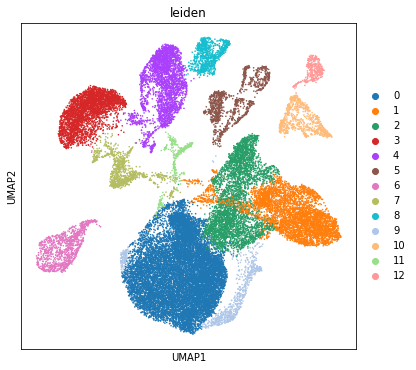

In [28]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_scl, color=['leiden'] ,size=10, use_raw=False)

In [19]:
for cluster in adata_scl.obs['leiden'].unique():
    cluster_data=adata_scl.obs.query('leiden == @cluster')
    cluster_anno_n=cluster_data.pre_cell_type.value_counts(normalize=True)
    print('Cluster %s: human SI pratio %.2e, mouse SI ratio %.2e' %
          (cluster,cluster_anno_n.loc['SI_Human'],cluster_anno_n.loc['SI_Mouse']))

Cluster 1: human SI pratio 2.19e-04, mouse SI ratio 0.00e+00
Cluster 6: human SI pratio 9.64e-01, mouse SI ratio 0.00e+00
Cluster 0: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 2: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 5: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 9: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 12: human SI pratio 0.00e+00, mouse SI ratio 9.34e-01
Cluster 10: human SI pratio 0.00e+00, mouse SI ratio 1.30e-03
Cluster 4: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 3: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 8: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 7: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 11: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00


#C: Most SI cells are in clusters 6 and 12 - but not all. Thus thgose two clusters and other previously annotated SI cells will be removed.

In [30]:
si_clusters=['6','12']
cells_retain=adata_scl.obs.query(
    'leiden not in @si_clusters & pre_cell_type != "SI_Human" & pre_cell_type != "SI_Mouse" ').index
adata=adata[cells_retain,:]
adata_scl=adata_scl[cells_retain,:]

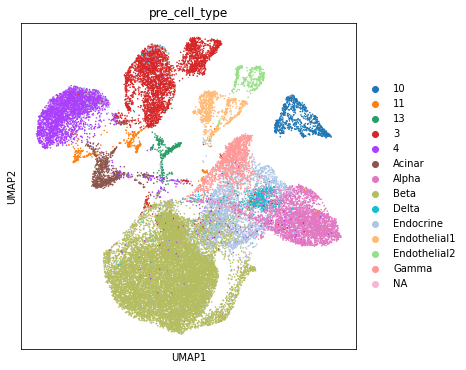

In [31]:
sc.pl.umap(adata_scl,color='pre_cell_type',s=10)

In [32]:
print('N cells after spike-in filtering:',adata.shape[0])

N cells after spike-in filtering: 33331


Coloured by treatment:

In [12]:
metadata=pd.read_excel('/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
                      sheet_name='spikein_drug'.replace('_ref','').replace('_nonref',''))
samples=adata.obs.file.unique()
col='design'
value_map={sample:metadata.query('sample_name =="'+sample+'"')[col].values[0] for sample in samples}
adata.obs[col]=adata.obs.file.map(value_map)

... storing 'design' as categorical


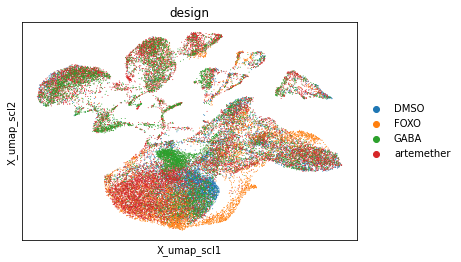

In [13]:
sc.pl.embedding(adata,'X_umap_scl',color=['design'])

Trying to set attribute `.obs` of view, copying.


SRR10751509 (1066, 17709)
SRR10751504 (3301, 17709)


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


SRR10751514 (1437, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751503 (1875, 17709)


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


SRR10751513 (909, 17709)
SRR10751507 (1322, 17709)
SRR10751502 (6164, 17709)


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


SRR10751508 (3082, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751512 (776, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751510 (1955, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751505 (1526, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751515 (909, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751516 (1570, 17709)


Trying to set attribute `.obs` of view, copying.


SRR10751511 (1877, 17709)
SRR10751506 (5562, 17709)


Trying to set attribute `.obs` of view, copying.


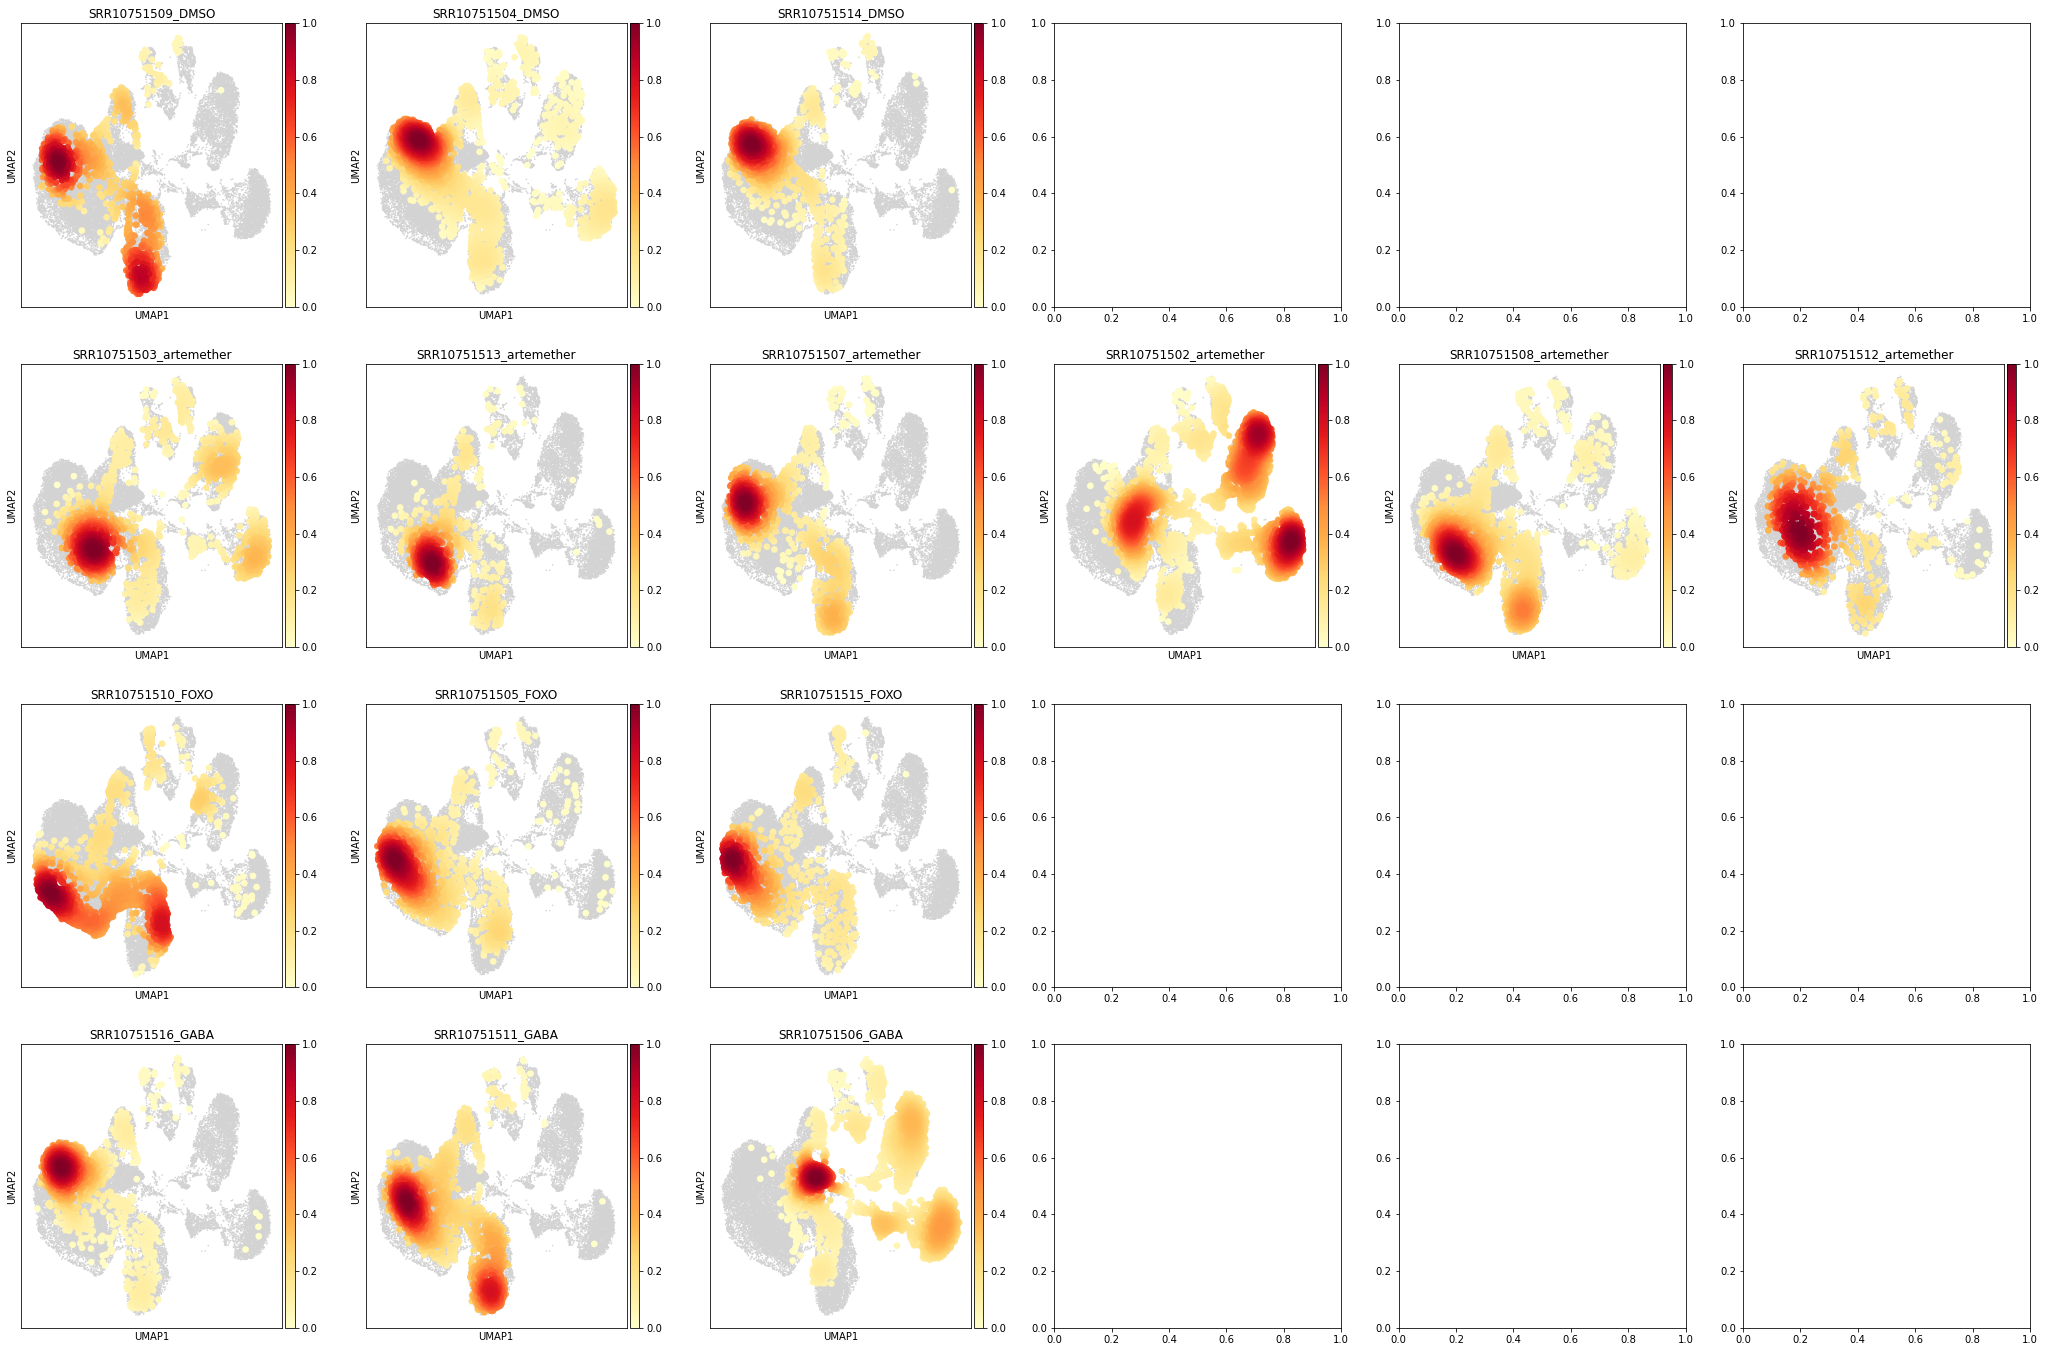

In [17]:
fig_rows=adata.obs.design.unique().shape[0]
fig_cols=max(
    [adata.obs.query('design ==@design').file.unique().shape[0] 
     for design in adata.obs.design.unique()])
rcParams['figure.figsize']= (6*fig_cols,6*fig_rows)
fig,axs=plt.subplots(fig_rows,fig_cols)
# Calculagte density
for row_idx,design in enumerate(adata.obs.design.unique()):
    for col_idx,sample in enumerate(adata.obs.query('design ==@design').file.unique()):
        subset=adata.obs.file==sample
        adata_ss=adata[subset,:]
        if adata_ss.shape[0]>=20:
            print(sample,adata_ss.shape)
            sc.tl.embedding_density(adata_ss)
            sc.pl.umap(adata,ax=axs[row_idx,col_idx],s=10,show=False)
            sc.pl.embedding_density(adata_ss,ax=axs[row_idx,col_idx],title=sample+'_'+design,show=False) 

## Cell cycle
Performed separately for individual batches.

### Seurat/Scanpy - score by G2M and S

In [33]:
# Load mouse cell cycle genes
cell_cycle_mm=pd.read_table('/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/cell_cycle_mm_Macosko2015.tsv',sep='\t')

Use cell cycle genes that overlap HVGs (from different batches). Display these genes on HVG plots (with non-phase genes being marked as .NA).

Use G2/M and M gene sets for G2/M annotation and S gene set for S annotation.

G1/S N genes: 92 overlap var: 90 overlap hvg (all): 17
S N genes: 96 overlap var: 95 overlap hvg (all): 17
G2/M N genes: 127 overlap var: 126 overlap hvg (all): 26
M N genes: 143 overlap var: 142 overlap hvg (all): 31
M/G1 N genes: 108 overlap var: 107 overlap hvg (all): 19
N genes for scoring S: 17 and G2/M: 57


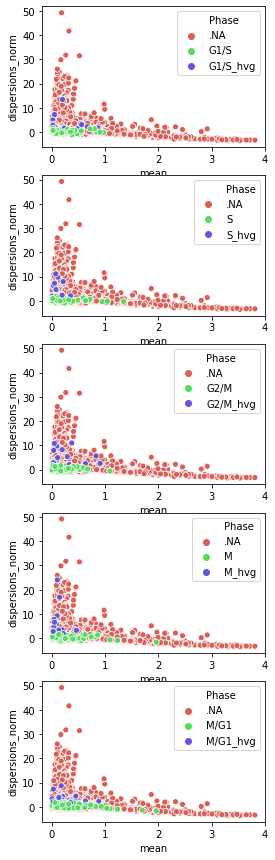

In [34]:
# How many of the cell cycle phase genes are present in HVG and in var and how variable they are
hvg=set(adata.var_names[adata.var.highly_variable])
i=0
rcParams['figure.figsize']=(4,15)
fig,axs=plt.subplots(5)
s_hvg=[]
g2m_hvg=[]
for phase in cell_cycle_mm.Phase.unique():
    genes_phase = set(cell_cycle_mm.query('Phase =="'+phase+'"').Gene)
    overlap_var = set(adata.var_names) & genes_phase
    overlap_hvg = hvg & genes_phase
    print(phase,'N genes:',len(genes_phase),'overlap var:',len(overlap_var),'overlap hvg (all):',len(overlap_hvg))
    phase_df=pd.DataFrame([phase]*len(overlap_var),index=overlap_var,columns=['Phase']).reindex(adata.var_names).fillna('.NA').sort_values('Phase')
    phase_df.loc[overlap_hvg,'Phase']=phase+'_hvg'
    phase_df['mean']=adata.var.means
    phase_df['dispersions_norm']=adata.var.dispersions_norm
    sb.scatterplot(x="mean", y="dispersions_norm", hue="Phase",data=phase_df,ax=axs[i],palette='hls')
    i+=1
    if phase == 'S':
        s_hvg.extend(overlap_hvg)
    if phase in ['G2/M','M']:
        g2m_hvg.extend(overlap_hvg)
        
print('N genes for scoring S:',len(s_hvg),'and G2/M:',len(g2m_hvg))

Cell cycle annotation

In [35]:
# Annotated cell cycle per batch
adata.obs['S_score']= np.zeros(adata.shape[0])
adata.obs['G2M_score'] = np.zeros(adata.shape[0])
adata.obs['phase'] = np.zeros(adata.shape[0])

for batch in enumerate(adata.obs['file'].cat.categories):
    batch=batch[1]
    idx = adata.obs.query('file=="'+batch+'"').index
    adata_tmp = adata[idx,:].copy()
    sc.tl.score_genes_cell_cycle(adata_tmp, s_genes=s_hvg, g2m_genes=g2m_hvg,use_raw=False)
    adata.obs.loc[idx,'S_score'] = adata_tmp.obs['S_score']
    adata.obs.loc[idx,'G2M_score'] = adata_tmp.obs['G2M_score']
    adata.obs.loc[idx,'phase'] = adata_tmp.obs['phase']
    
del adata_tmp

Trying to set attribute `.obs` of view, copying.


In [36]:
# Count of cells annotated to each phase
adata.obs['phase'].value_counts()

G1     18228
S       9951
G2M     5152
Name: phase, dtype: int64

Display cell cycle score distributions and annotation.

... storing 'phase' as categorical


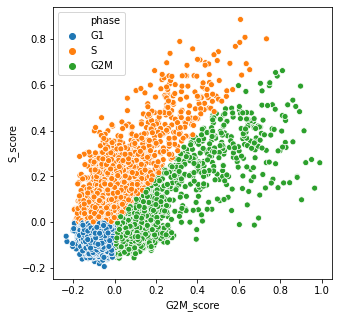

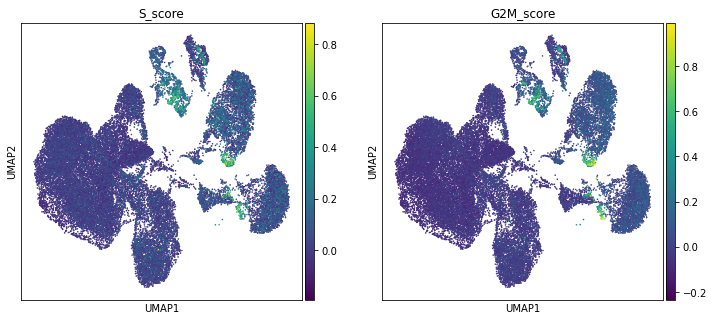

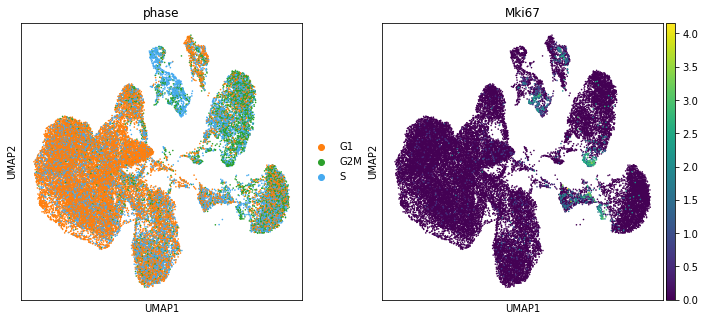

In [37]:
adata.uns['phase_colors']=['#ff7f0e', '#2ca02c','#46aaf0']

rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='G2M_score',y='S_score',hue='phase',data=adata.obs)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=10, use_raw=False)
sc.pl.umap(adata, color=['phase','Mki67'], size=10, use_raw=False)

#C: There might be some proliferating populations, but it is not very clear as many cells that probably are not proliferating (low Mki67 expression - not G2M) are annotated as cycling / G2M.

 ### Cyclone - based on G1, S, and G2/M scores

Add gene Entrez IDs to adata in order to map genes to cell cycle database.

In [17]:
#adata.obs.drop(['phase_cyclone','g1_cyclone','g2m_cyclone','s_cyclone'],axis=1,inplace=True)

In [18]:
# Adata genes for R
genes=adata.var_names

#C: Current Ensembl release 101

In [19]:
%%R -i genes -o gene_ids
# Extract Ensembl gene IDs
mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
gene_ids = getBM(attributes = c("mgi_symbol",'ensembl_gene_id'), 
                 filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=FALSE)

In [20]:
# Add gene ids to adata, use only genes with unique mapped ensembl ids
gene_ids.drop_duplicates(subset='mgi_symbol', keep=False, inplace=True)
gene_ids.index=gene_ids.mgi_symbol
gene_ids=gene_ids.reindex(list(adata.var_names))
adata.var['EID']=gene_ids.ensembl_gene_id

In [21]:
# Prepare R data for cyclonee
x_mat=adata.X.T
gene_ids=adata.var.EID
batches=adata.obs.file
cells=adata.obs.index

In [22]:
%%R -i x_mat -i gene_ids -i batches -i cells -o cyclone_anno
# Cyclone cell scores, calculated separately for each batch
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
phases<-c()
s<-c()
g2m<-c()
g1<-c()
cells_order<-c()
for(batch in unique(batches)){
    # Select batch data
    x_mat_batch=x_mat[,batches==batch]
    print(batch,dim(x_mat_batch[1]))
    # Scores
    assignments <- cyclone(x_mat_batch, mm.pairs, gene.names=gene_ids,BPPARAM=MulticoreParam(workers = 16))
    phases<-c(phases,assignments$phases)
    s<-c(s,assignments$score$S)
    g2m<-c(g2m,assignments$score$G2M)
    g1<-c(g1,assignments$score$G1)
    # Save cell order
    cells_order<-c(cells_order,cells[batches==batch])
}
cyclone_anno<-data.frame(phase_cyclone=phases,s_cyclone=s,g2m_cyclone=g2m,g1_cyclone=g1)
rownames(cyclone_anno)<-cells_order

[1] "SRR10751509"
[1] "SRR10751503"
[1] "SRR10751510"
[1] "SRR10751504"
[1] "SRR10751513"
[1] "SRR10751514"
[1] "SRR10751507"
[1] "SRR10751505"
[1] "SRR10751516"
[1] "SRR10751511"
[1] "SRR10751502"
[1] "SRR10751508"
[1] "SRR10751506"
[1] "SRR10751515"
[1] "SRR10751512"


In [23]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1     32414
G2M      531
S        386
Name: phase_cyclone, dtype: int64

In [24]:
# Add cyclone annotation to adata
cyclone_anno=cyclone_anno.reindex(adata.obs.index)
adata.obs=pd.concat([adata.obs,cyclone_anno],axis=1)

In [29]:
# replace NA annotation of cell phases
adata.obs.phase_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata.obs.phase_cyclone.fillna('NA',inplace=True)

In [35]:
#Check if any values are na
print('NA or nan:')
print((adata.obs[['phase_cyclone']]=='NA').sum(axis=0))
print((adata.obs[['g1_cyclone','g2m_cyclone','s_cyclone']].isna()).sum(axis=0))

NA or nan:
phase_cyclone    0
dtype: int64
g1_cyclone     0
g2m_cyclone    0
s_cyclone      1
dtype: int64


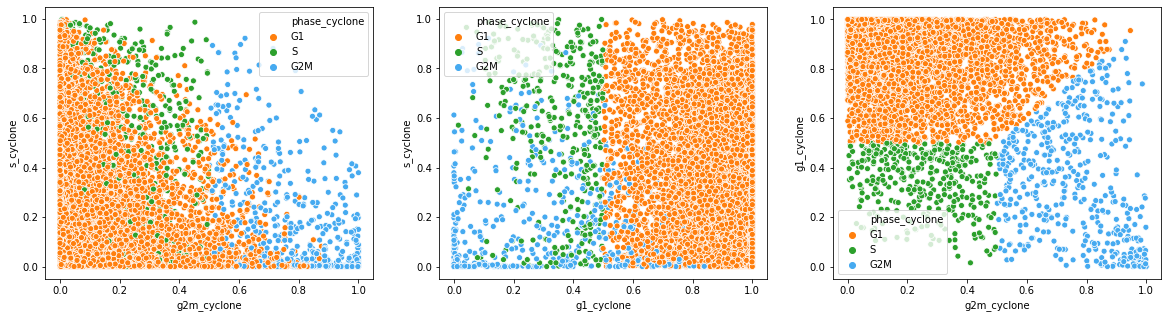

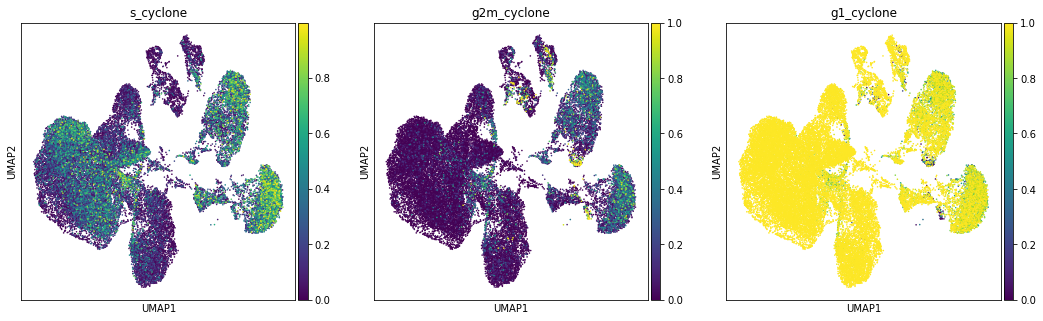

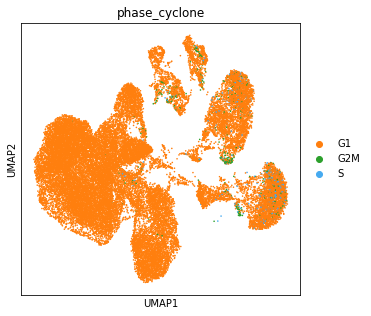

In [37]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize']=(20,5)
fig,axs=plt.subplots(1,3)
palette=sb.color_palette(['#ff7f0e', '#2ca02c','#46aaf0'])
sb.scatterplot(x='g2m_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[0],palette=palette)
sb.scatterplot(x='g1_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[1],palette=palette)
sb.scatterplot(x='g2m_cyclone',y='g1_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[2],palette=palette)
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['s_cyclone', 'g2m_cyclone','g1_cyclone'], size=10, use_raw=False)
adata.uns['phase_cyclone_colors']=['#ff7f0e', '#2ca02c','#46aaf0']
sc.pl.umap(adata, color=['phase_cyclone'], size=10, use_raw=False)

#C: The cyclone results seem more reliable based on Mki67 expression (above) and embedding.

## Sex scores
#C: All animals were male - no sex assignment

Extract expressed genes from X and Y chromosome and score their expression, separately for each batch.

Add chromosome information:

In [46]:
# Gene names for R for chromosome assignment
genes=adata.var_names

In [47]:
%%R -i genes -o genes_chr
# Chromosome assignment 

mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
# Return duplicated results - e.g. one gene being annotated to multiple chromosomes
genes_chr = getBM(attributes = c("mgi_symbol",'chromosome_name'), filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=F)


In [48]:
# Remove genes annotated to non-standard chromosomes and 
# confirm that each gene is now annotated to only one chromosome
mouse_chromosomes=[str(i) for i in range(1,20)]+['X','Y','MT']
genes_chr_filtered=genes_chr.query('chromosome_name in @mouse_chromosomes')
#Remove duplicated rows (gene was returned multiple times with the same chromosome)
genes_chr_filtered=genes_chr_filtered.drop_duplicates()
print('Each gene has one annotated chromosome:',
      genes_chr_filtered.mgi_symbol.unique().shape[0]==genes_chr_filtered.shape[0])
print('N genes with chromosomes:',genes_chr_filtered.shape[0],'out of',adata.shape[1],'genes')

Each gene has one annotated chromosome: True
N genes with chromosomes: 17671 out of 17709 genes


In [49]:
# Add chromosomes in adata
genes_chr_filtered.index=genes_chr_filtered.mgi_symbol
genes_chr_filtered=genes_chr_filtered.reindex(adata.var_names)
adata.var['chromosome']=genes_chr_filtered['chromosome_name']

Extract X and Y HVGs and compare their number to all expressed X and Y genes.

In [50]:
# Select X and Y genes that are HVG
x_hvg = adata.var.query('chromosome=="X" & highly_variable').index
y_hvg = adata.var.query('chromosome=="Y" & highly_variable').index
print('X HVG:',len(x_hvg),'/',adata.var.query('chromosome=="X"').shape[0],
      'Y HVG:',len(y_hvg),'/',adata.var.query('chromosome=="Y"').shape[0])

X HVG: 81 / 556 Y HVG: 0 / 7


Show Y gene expression on UMAP.

... storing 'chromosome' as categorical


Y specific HVG


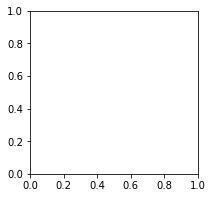

Y specific non-HVG


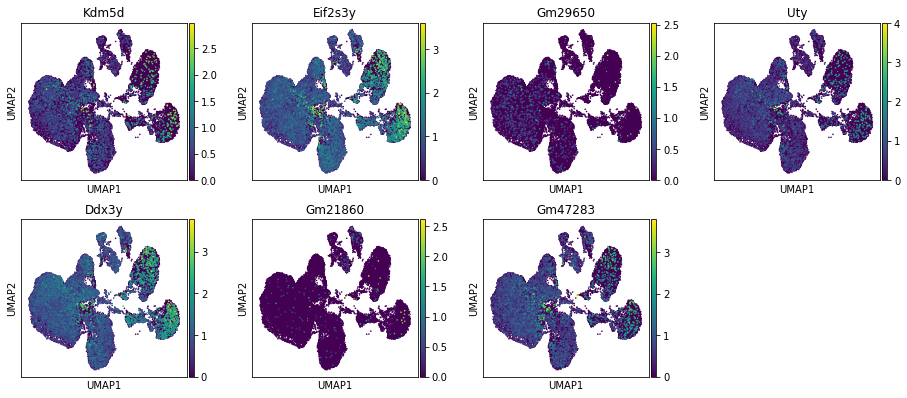

In [51]:
# Show Y HVGs and Y non-HVGs
rcParams['figure.figsize']=(3,3)
print('Y specific HVG')
sc.pl.umap(adata, color=y_hvg, size=10, use_raw=False)
print('Y specific non-HVG')
sc.pl.umap(adata, color=adata.var.query('chromosome=="Y"& ~highly_variable').index, size=10, use_raw=False)

#C: Due to low number of expressed Y genes both HVG and non-HVG genes will be used. Genes Gm21860  and Gm29650  will not be used for Y scoring due to low expression.
For X chromosome only HVG will be used. 

Score cells:

In [57]:
# Prepare final scoring gene sets for X and Y
y_all=adata.var.query('chromosome=="Y"').index
#C Remove these two genes for consistency with other datasets
y_selected=[gene for gene in y_all if gene not in ['Gm21860','Gm29650']]
x_selected=list(x_hvg)
print('N selected genes from Y:',len(y_selected),'and from X:',len(x_selected))

N selected genes from Y: 5 and from X: 81


In [58]:
#Do not use the smaller gene set as controll size as Y gene set is very small
#ctrl_size = min(len(x_genes), len(y_genes))

# For performing it on all batches together
#sc.tl.score_genes(adata, x_selected, score_name = 'x_score', use_raw=False)
#sc.tl.score_genes(adata, y_selected, score_name = 'y_score',use_raw=False)

# Compute sex score per batch
adata.obs['x_score']= np.zeros(adata.shape[0])
adata.obs['y_score'] = np.zeros(adata.shape[0])

for batch in enumerate(adata.obs['file'].cat.categories):
    batch=batch[1]
    idx = adata.obs.query('file=="'+batch+'"').index
    adata_tmp = adata[idx,:].copy()
    sc.tl.score_genes(adata_tmp, x_selected, score_name = 'x_score', use_raw=False)
    sc.tl.score_genes(adata_tmp, y_selected, score_name = 'y_score',use_raw=False)
    adata.obs.loc[idx,'y_score'] = adata_tmp.obs['y_score']
    adata.obs.loc[idx,'x_score'] = adata_tmp.obs['x_score']
    
del adata_tmp

Plot X and Y scores

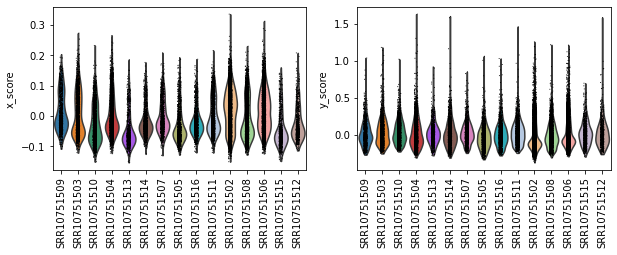

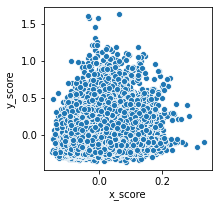

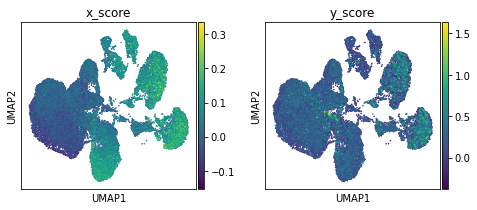

<AxesSubplot:xlabel='y_score'>

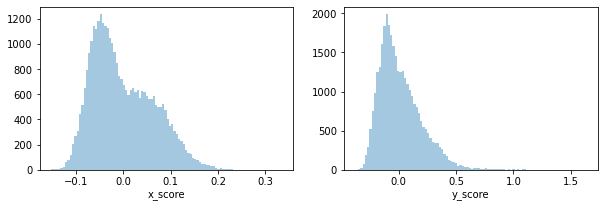

In [59]:
rcParams['figure.figsize']=(10,3)
fig,axs=plt.subplots(1,2)
# Scores across batches
sc.pl.violin(adata, ['x_score'], groupby='file', size=1, log=False,rotation=90,ax=axs[0],show=False)
sc.pl.violin(adata, ['y_score'], groupby='file', size=1, log=False,rotation=90,ax=axs[1],show=False)
plt.show()
# X vs Y score
rcParams['figure.figsize']=(3,3)
sb.scatterplot(x='x_score',y='y_score',data=adata.obs)
# Distribution of scores
sc.pl.umap(adata, color=['x_score','y_score'] ,size=10, use_raw=False)
rcParams['figure.figsize']=(10,3)
fig,axs=plt.subplots(1,2)
sb.distplot(adata.obs['x_score'],  kde=False,  bins=100,ax=axs[0])
sb.distplot(adata.obs['y_score'],  kde=False,  bins=100,ax=axs[1])

<AxesSubplot:xlabel='y_score'>

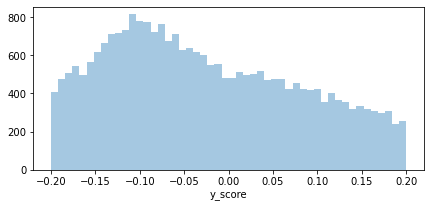

In [61]:
# More detailed plot of y_score region of interest
rcParams['figure.figsize']=(7,3)
sb.distplot(adata.obs.query('y_score>-0.2 & y_score<0.2')['y_score'],  kde=False,  bins=50)

#C: There is no bimodal distibution in Y score (as in mixed-sex datasets). X score seems to be cell type specific again. Thus sex will not be annotated.

## Save intermediate results before cell type annotation

In [39]:
h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)

# Cell type annotation

In [10]:
adata=h.open_h5ad(shared_folder+"data_annotated.h5ad",unique_id2=UID2)

## Endo high annotation

In [6]:
# Normalise raw data for cell type scoring
adata_rawnorm=adata.raw.to_adata().copy()
adata_rawnorm.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata_rawnorm)
adata_rawnorm.X = np.asarray(adata_rawnorm.X)
adata_rawnorm.obs=adata.obs.copy()

#### Ins

In [7]:
# Compute Ins score
sc.tl.score_genes(adata_rawnorm, gene_list=['Ins1','Ins2'], score_name='ins_score',  use_raw=False)

<ipython-input-14-b8e48502e0ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_scores['ins_score_norm']=pp.minmax_scale(ins_scores.ins_score)


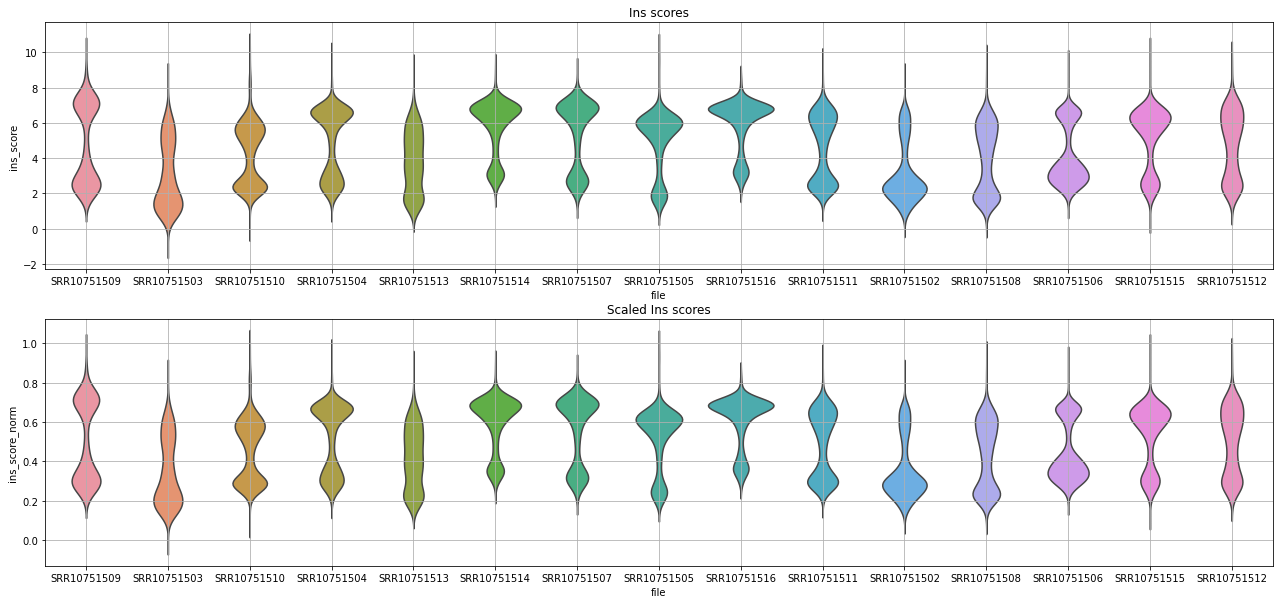

In [14]:
#sc.pl.violin(adata_rawnorm, keys=['ins_score'], groupby='file', stripplot=False, jitter=True)
ins_scores=adata_rawnorm.obs[['ins_score','file']]
ins_scores['ins_score_norm']=pp.minmax_scale(ins_scores.ins_score)
rcParams['figure.figsize']=(22,10)
fig,axs=plt.subplots(2,1)
sb.violinplot(x='file',y='ins_score',data=ins_scores,inner=None,ax=axs[0])
axs[0].title.set_text('Ins scores')
axs[0].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled Ins scores')
axs[1].grid()
#sb.violinplot(x='file',y='ins_score_norm',data=ins_scores[ins_scores.ins_score_norm>0.15],inner=None,ax=axs[2])
#axs[2].title.set_text('Scaled Ins scores without very low Ins cells')
#axs[2].grid()

In [16]:
# Find ins high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR10751509':0.5,'SRR10751503':0.4,'SRR10751510':0.4,'SRR10751504':0.5,'SRR10751513':0.5,
 'SRR10751514':0.5,'SRR10751507':0.5,'SRR10751505':0.4,'SRR10751516':0.5,'SRR10751511':0.45,'SRR10751502':0.45,
 'SRR10751508':0.4,'SRR10751506':0.5,'SRR10751515':0.45,'SRR10751512':0.45}
adata_rawnorm.obs['ins_high']=ins_scores.apply(lambda x: x.ins_score_norm > file_thresholds[x.file], axis=1)
print('Proportion of ins high across samples:')
adata_rawnorm.obs[['file','ins_high']].groupby('file').ins_high.value_counts(normalize=True,sort=False)

Proportion of ins high across samples:


file         ins_high
SRR10751509  False       0.530019
             True        0.469981
SRR10751503  False       0.636267
             True        0.363733
SRR10751510  False       0.432225
             True        0.567775
SRR10751504  False       0.412905
             True        0.587095
SRR10751513  False       0.662266
             True        0.337734
SRR10751514  False       0.237300
             True        0.762700
SRR10751507  False       0.339637
             True        0.660363
SRR10751505  False       0.234600
             True        0.765400
SRR10751516  False       0.214650
             True        0.785350
SRR10751511  False       0.435269
             True        0.564731
SRR10751502  False       0.758598
             True        0.241402
SRR10751508  False       0.449059
             True        0.550941
SRR10751506  False       0.683927
             True        0.316073
SRR10751515  False       0.297030
             True        0.702970
SRR10751512  False       0

In [17]:
# Add info about ins high to main adata and save it
adata.obs['ins_score']=adata_rawnorm.obs['ins_score']
adata.obs['ins_high']=adata_rawnorm.obs['ins_high']

#### Gcg

In [7]:
genes=['Gcg']
score_name='gcg'

In [8]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-12-4d3048b44b8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


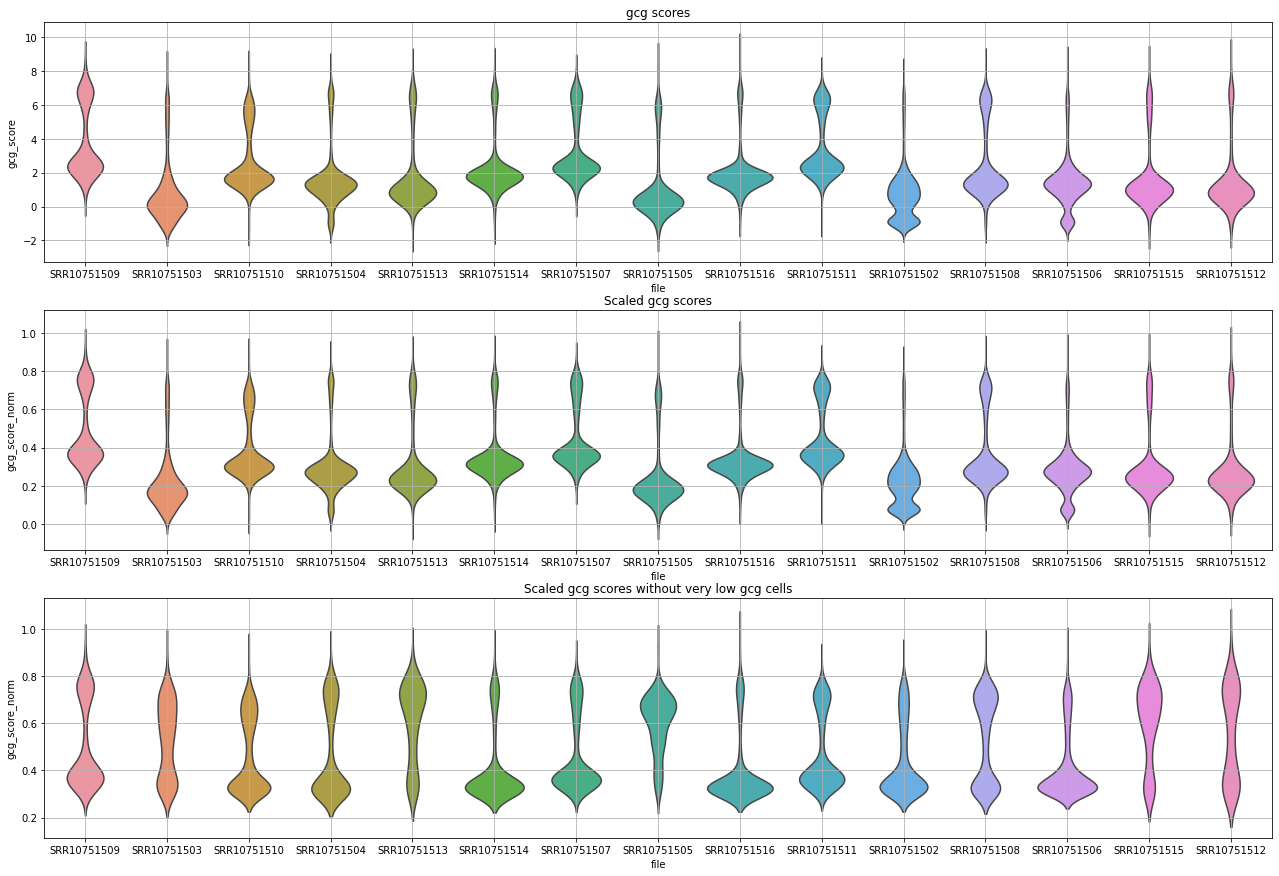

In [12]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(22,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.3],
             inner=None,ax=axs[2])
axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
axs[2].grid()

In [13]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR10751509':0.55,'SRR10751503':0.45,'SRR10751510':0.5,'SRR10751504':0.5,'SRR10751513':0.5,
 'SRR10751514':0.55,'SRR10751507':0.5,'SRR10751505':0.45,'SRR10751516':0.55,'SRR10751511':0.5,'SRR10751502':0.5,
 'SRR10751508':0.5,'SRR10751506':0.5,'SRR10751515':0.45,'SRR10751512':0.55}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of gcg high across samples:


file         gcg_high
SRR10751509  False       0.670732
             True        0.329268
SRR10751503  False       0.890133
             True        0.109867
SRR10751510  False       0.761637
             True        0.238363
SRR10751504  False       0.891245
             True        0.108755
SRR10751513  False       0.836084
             True        0.163916
SRR10751514  False       0.870564
             True        0.129436
SRR10751507  False       0.713313
             True        0.286687
SRR10751505  False       0.861730
             True        0.138270
SRR10751516  False       0.901274
             True        0.098726
SRR10751511  False       0.685136
             True        0.314864
SRR10751502  False       0.947274
             True        0.052726
SRR10751508  False       0.758274
             True        0.241726
SRR10751506  False       0.930780
             True        0.069220
SRR10751515  False       0.842684
             True        0.157316
SRR10751512  False       0

In [14]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

#### Sst

In [15]:
genes=['Sst']
score_name='sst'

In [16]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-18-1c62604dd3f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


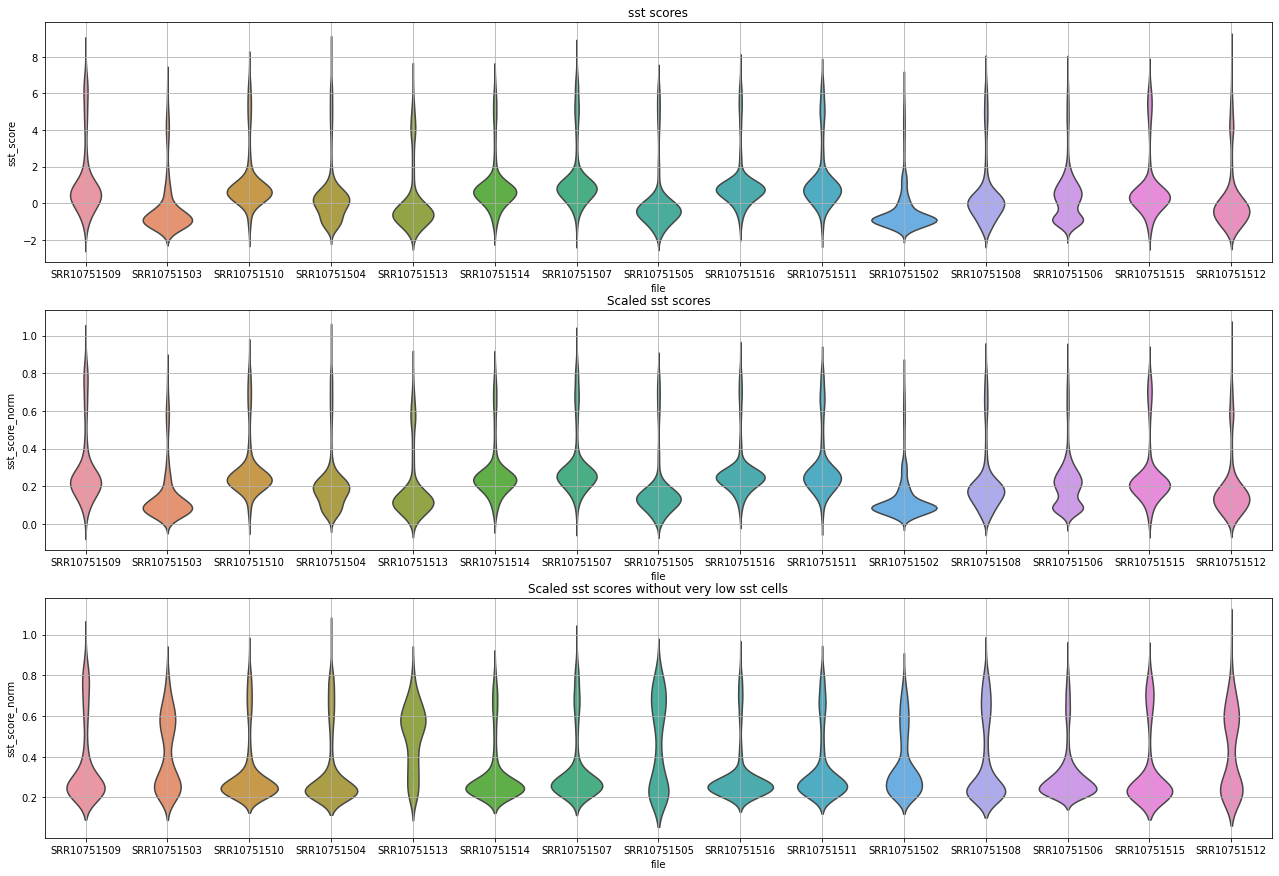

In [18]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(22,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.2],
             inner=None,ax=axs[2])
axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
axs[2].grid()

In [19]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR10751509':0.5,'SRR10751503':0.45,'SRR10751510':0.5,'SRR10751504':0.45,'SRR10751513':0.4,
 'SRR10751514':0.5,'SRR10751507':0.5,'SRR10751505':0.5,'SRR10751516':0.5,'SRR10751511':0.5,'SRR10751502':0.45,
 'SRR10751508':0.45,'SRR10751506':0.5,'SRR10751515':0.5,'SRR10751512':0.45}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of sst high across samples:


file         sst_high
SRR10751509  False       0.846154
             True        0.153846
SRR10751503  False       0.917333
             True        0.082667
SRR10751510  False       0.885422
             True        0.114578
SRR10751504  False       0.913057
             True        0.086943
SRR10751513  False       0.855886
             True        0.144114
SRR10751514  False       0.897008
             True        0.102992
SRR10751507  False       0.849470
             True        0.150530
SRR10751505  False       0.920052
             True        0.079948
SRR10751516  False       0.910191
             True        0.089809
SRR10751511  False       0.850826
             True        0.149174
SRR10751502  False       0.952466
             True        0.047534
SRR10751508  False       0.887735
             True        0.112265
SRR10751506  False       0.941208
             True        0.058792
SRR10751515  False       0.876788
             True        0.123212
SRR10751512  False       0

In [20]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

In [ ]:
#### Ppy

In [21]:
genes=['Ppy']
score_name='ppy'

In [22]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-25-eb4faf218043>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


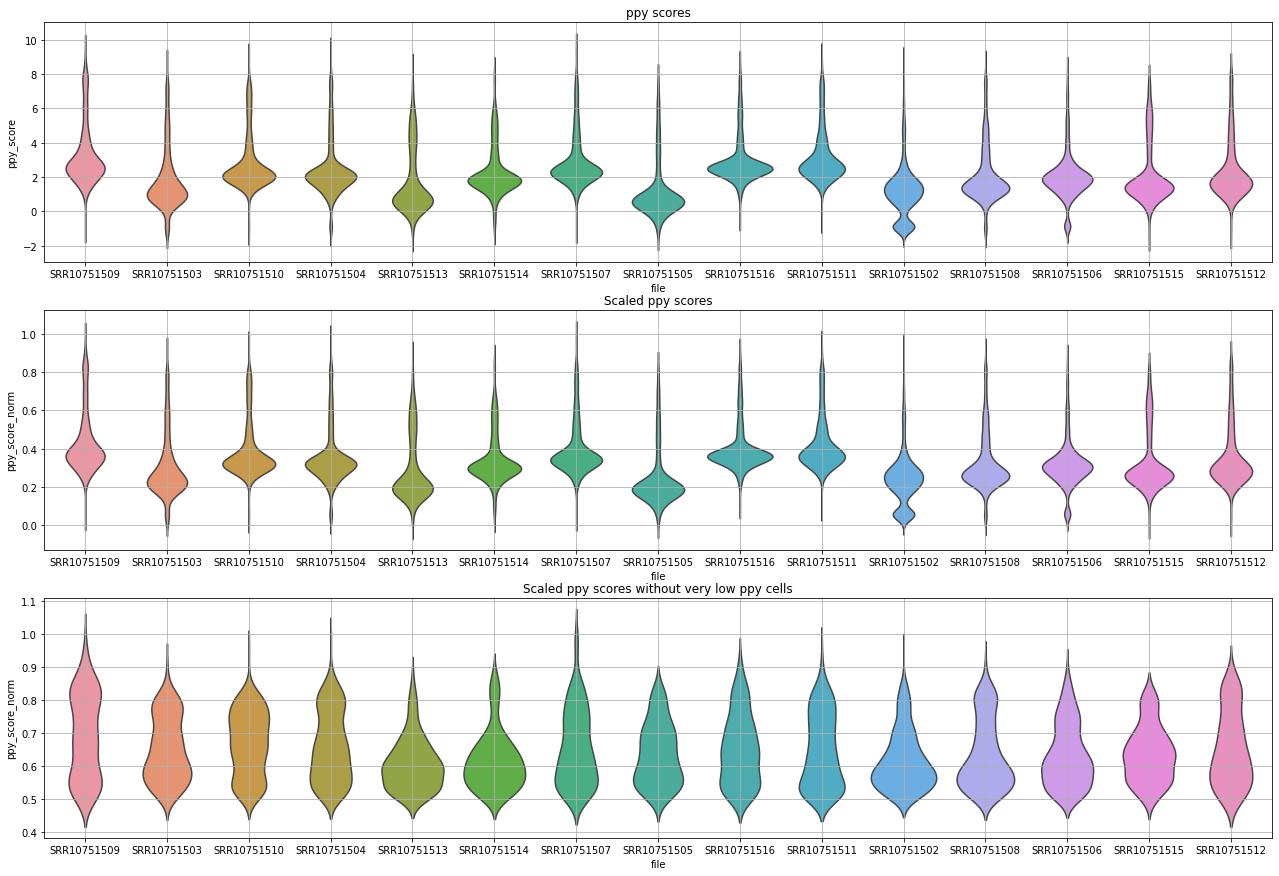

In [25]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(22,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.5],
             inner=None,ax=axs[2])
axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
axs[2].grid()

In [26]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR10751509':0.75,'SRR10751503':0.75,'SRR10751510':0.7,'SRR10751504':0.75,'SRR10751513':0.75,
 'SRR10751514':0.75,'SRR10751507':0.7,'SRR10751505':0.75,'SRR10751516':0.75,'SRR10751511':0.7,'SRR10751502':0.75,
 'SRR10751508':0.7,'SRR10751506':0.7,'SRR10751515':0.75,'SRR10751512':0.75}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of ppy high across samples:


file         ppy_high
SRR10751509  False       0.909944
             True        0.090056
SRR10751503  False       0.969067
             True        0.030933
SRR10751510  False       0.928900
             True        0.071100
SRR10751504  False       0.963950
             True        0.036050
SRR10751513  False       0.988999
             True        0.011001
SRR10751514  False       0.986082
             True        0.013918
SRR10751507  False       0.936460
             True        0.063540
SRR10751505  False       0.985583
             True        0.014417
SRR10751516  False       0.969427
             True        0.030573
SRR10751511  False       0.924880
             True        0.075120
SRR10751502  False       0.993511
             True        0.006489
SRR10751508  False       0.961064
             True        0.038936
SRR10751506  False       0.979144
             True        0.020856
SRR10751515  False       0.976898
             True        0.023102
SRR10751512  False       0

In [27]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

#### Save

In [29]:
h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)

## Annotation transfer
Annotation transfer with scARches operation and logistic regression.

In [10]:
# Load annotation and add to adata
anno=pd.read_table(shared_folder+'scArches_map_ref/celltype_predicitions.tsv',index_col=0)
adata.obs['cell_type_transfered']=anno.loc[adata.obs_names,:]['cell_type']

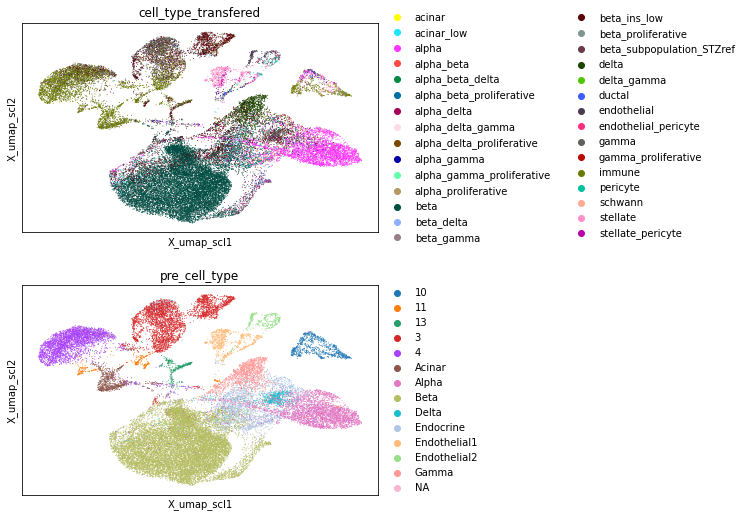

In [16]:
sc.pl.embedding(adata,'X_umap_scl',color=['cell_type_transfered','pre_cell_type'],ncols=1)

Main cell types - subset of all cell types.  Show only this part of adata.

Trying to set attribute `.uns` of view, copying.


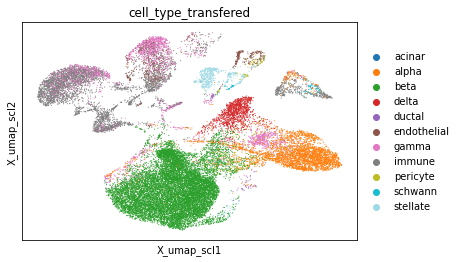

In [23]:
main_types=['acinar','alpha','beta','delta','endothelial','gamma','immune','pericyte','schwann','stellate','ductal']
sc.pl.embedding(adata[adata.obs.cell_type_transfered.isin(main_types)],
                'X_umap_scl',color=['cell_type_transfered'],ncols=1,palette='tab20')

In [27]:
adata_raw=adata.raw.to_adata().copy()
sc.pp.normalize_total(adata_raw, target_sum=1e4, exclude_highly_expressed=True,inplace=False)
sc.pp.log1p(adata_raw)
adata_rawnormalised=adata.copy()
adata_rawnormalised.raw=adata_raw
used_markers=list(dict.fromkeys([marker for marker_list in markers_selection.values() for marker in marker_list]))
gene_idx=adata_rawnormalised.raw.var_names.isin(used_markers)
genes=adata_rawnormalised.raw.var_names[gene_idx]
scaled_expression=pd.DataFrame(pp.minmax_scale(adata_rawnormalised.raw.X.toarray()[:, gene_idx]),
                               columns=genes,index=adata_rawnormalised.obs.index
                              )[[marker for marker in used_markers if marker in genes]]

In [24]:
markers_selection={
'immune':['Cd86','Cd74','Ptprc','Cd14','Cd52','Lyz2','Itgax','Adgre1'],
'schwann':['Sox10','Cmtm5','Ngfr','Plp1','Cryab'],
'stellate':['Col1a2','Pdgfra'],
'endothelial':['Plvap','Pecam1'],
'pericyte':['Ndufa4l2','Pdgfrb','Acta2','Cspg4','Des','Rgs5','Abcc9'],
'acinar':['Cpa1','Prss2'],
'ductal':['Muc1','Sox9','Anxa2','Bicc1','Spp1','Krt19','Pou3f1'],
'alpha':['Gcg'],
'beta':['Ins1','Ins2'],
'delta':['Sst'],
'gamma':['Ppy'],
'epsilon':['Ghrl']
}

Text(0.5, 1.0, 'cell_type_transfered')

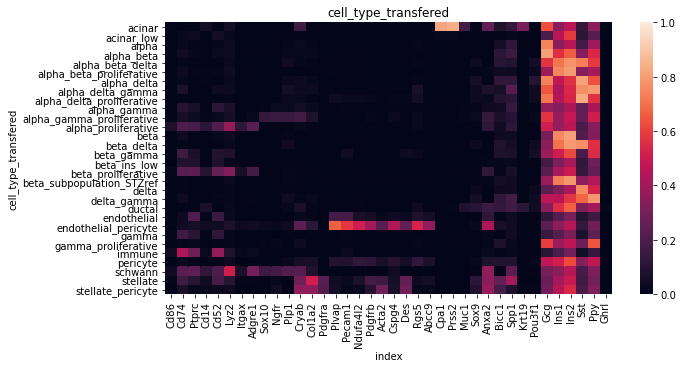

In [28]:
rcParams['figure.figsize']=(10,5)
fig,ax=plt.subplots()
sb.heatmap(scaled_expression.groupby(adata.obs['cell_type_transfered']).mean(),yticklabels=1,xticklabels=1,
          vmin=0,vmax=1)
ax.set_title('cell_type_transfered')

Text(0.5, 1.0, 'pre_cell_type')

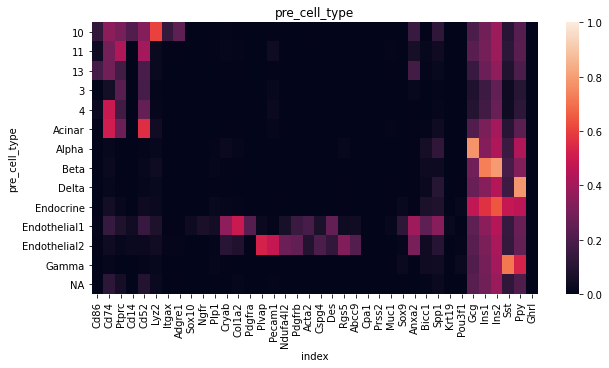

In [29]:
rcParams['figure.figsize']=(10,5)
fig,ax=plt.subplots()
sb.heatmap(scaled_expression.groupby(adata.obs['pre_cell_type']).mean(),yticklabels=1,xticklabels=1,
          vmin=0,vmax=1)
ax.set_title('pre_cell_type')

#C: The marker heatmap is not very clean.

## De novo annotation

In [ ]:
raise NotImplementedError()

## Clustering

#### Leiden clustering on log transformed data.

In [ ]:
sc.tl.leiden(adata,resolution=0.4)

In [ ]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata, color=['leiden'] ,size=10, use_raw=False)

#### Seurat style clustering

#### Leiden clustering on log transformed z-scaled data.

Scaling already done above

In [ ]:
#del adata_scl.uns['sex_colors']
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_scl, color=['file','phase_cyclone'] ,size=10, use_raw=False,wspace=0.3)

In [ ]:
# Clustering resolution
res=0.5

In [ ]:
# Cluster scaled data
sc.tl.leiden(adata_scl, resolution=res, key_added='leiden_scaled_r'+str(res), directed=True, use_weights=True)

In [ ]:
# Compare UMAPs and clusters on scaled data
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_scl, color=['leiden_scaled_r'+str(res)] ,size=10, use_raw=False)

In [ ]:
#sc.pl.umap(adata_scl, color=['pre_cell_type'] ,size=10, use_raw=False)

#C: Umaps and clusterings on z-scaled data and non-z-scaled data perform similarly. z-scaled data will be used for consistency with other analysed studies.

## Cell type annotation

In [ ]:
# Normalise raw data for plotting and cell type scoring
adata_raw=adata_scl.raw.to_adata().copy()
sc.pp.normalize_total(adata_raw, target_sum=1e4, exclude_highly_expressed=True,inplace=False)
sc.pp.log1p(adata_raw)
adata_rawnormalised=adata_scl.copy()
adata_rawnormalised.raw=adata_raw
del adata_raw

In [ ]:
# Markers data
markers=pd.read_excel('/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/markers.xlsx',
                          sheet_name='mice')

In [ ]:
# Subset markers to non-immature and non-dedifferentiated for initial annotation
print('Subtypes (original):',markers.Subtype.unique())
remove_subtype=['immature','dedifferentiated']
remove_subtype=[]
markers_filter=markers.query('Subtype not in @remove_subtype')

In [ ]:
# Plot markers for each cell type
# Plot markers for each cell type
for cell_type in sorted(list(markers_filter.Cell.unique()), key=str.lower):
    print(cell_type)
    genes=list(markers_filter.query('Cell == "'+cell_type+'"').Gene)
    # Retain genes present in raw var_names
    missing=[gene for gene in genes if gene not in adata.raw.var_names]
    genes=[gene for gene in genes if gene in adata.raw.var_names]
    if len(genes)>0:
        print('Missing genes:',missing)
        rcParams['figure.figsize']=(4,4)
        #sc.pl.umap(adata_rawnormalised, color=['pre_cell_type'],size=10, use_raw=True)
        sc.pl.umap(adata_rawnormalised, color=genes ,size=10, use_raw=True)
    else:
        print('No availiable genes (out of:',missing,')\n')

In [ ]:
# Selected markers that seem to be able to distinguish between cell types
# Use only hormone genes for endocrine cells
markers_selection={
'immune':['Cd86','Cd74','Ptprc','Cd52','Cd14','Lyz2'],
'schwann':['Plp1','Cryab'],
'endothelial':['Plvap','Pecam1'],
'pericyte':['Ndufa4l2','Pdgfrb','Acta2','Cspg4','Des','Rgs5','Abcc9'],
'ductal':['Muc1','Sox9','Anxa2','Bicc1','Krt19','Pou3f1'],
'alpha':['Gcg'],
'beta':['Ins1','Ins2'],
'delta':['Sst'],
'gamma':['Ppy']
}
#markers_selection={
#'immune':['Cd74','Ptprc','Cd86','Adgre1','Lyz2','Cd86','Itgax','Cd52'],
#'schwann':['Sox10'],
#'stellate':['Col1a2','Pdgfra'],
#'endothelial':['Plvap','Pecam1'],
#'ductal':['Muc1','Sox9','Spp1','Krt19'],
#'acinar':['Cpa1','Prss2'],
#'beta':['Slc2a2','Ins1','Ins2'],
#'alpha':['Gcg','Irx1','Irx2'],
#'delta':['Sst','Hhex','Neurog3'],
#'gamma':['Ppy'],
#'epsilon':['Ghrl']
#}

### Marker expression scores
Score each cell for marker expression of each cell type. Cells can thus be annotated qith 0 to N cell types. The presence of annotations is then checked for each cluster.

In [ ]:
#Score cells for each cell type

# Save score column names 
scores=[]
for cell_type,genes in markers_selection.items():
    score_name=cell_type+'_score'
    scores.append(cell_type+'_score')
    sc.tl.score_genes(adata_rawnormalised, gene_list=genes, score_name=score_name,  use_raw=True)

In [ ]:
# Which clusters (column name) to analyse for cell scores
res=0.5
clusters_col='leiden_scaled_r'+str(res)

In [ ]:
# Add cluster information to the used adata
adata_rawnormalised.obs[clusters_col]=adata_scl.obs[clusters_col]

In [ ]:
# Plot scores distribution across clusters
rcParams['figure.figsize']=(10,3)
for score in scores:
    sc.pl.violin(adata_rawnormalised, keys=score, groupby=clusters_col, use_raw=True, stripplot=False)

In [ ]:
# Scores per cluster, scaled from 0 to 1 in each cell type
#C: Not very informative!
#scores_df=adata_rawnormalised.obs[scores+[clusters_col]]
#score_means=scores_df.groupby(clusters_col).mean()
#score_means=pd.DataFrame(pp.minmax_scale(score_means),index=score_means.index,columns=score_means.columns)
#sb.clustermap(score_means,yticklabels=1)

In [ ]:
# Scores normalised to interval [0,1] for each cell type - so that they can be more easily compared
scores_df_norm=adata_rawnormalised.obs[scores]
scores_df_norm=pd.DataFrame(pp.minmax_scale(scores_df_norm),columns=scores_df_norm.columns,index=adata_rawnormalised.obs.index)

In [ ]:
# Plot of normalised scores distribution in whole dataset, per cluster
rcParams['figure.figsize']=(20,3)
fig,ax=plt.subplots()
sb.violinplot(data=scores_df_norm,inner=None,ax=ax)
ax.grid()

In [ ]:
# Plot of normalised scores distribution, excluding low scores, per cluster
rcParams['figure.figsize']=(20,3)
fig,ax=plt.subplots()
sb.violinplot(data=scores_df_norm[scores_df_norm>0.1],inner=None,ax=ax)
ax.grid()

In [ ]:
# Check gamma score in gamma cluster to reset the threshold
# Cluster 5 contains only partialy gamma cells
rcParams['figure.figsize']=(20,3)
fig,ax1=plt.subplots()
a=ax1.hist(scores_df_norm.gamma_score[(adata_scl.obs[clusters_col]=='8').values],bins=100,alpha=0.5,color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax2 = ax1.twinx()
a=ax2.hist(scores_df_norm.gamma_score[(adata_scl.obs[clusters_col]!='8').values],bins=100,alpha=0.5,color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.axvline(0.75)

In [ ]:
# Thresholds for cell type assignemnt based on normalised scores
thresholds=[]
for col in scores_df_norm:
    threshold=0.5
    if col=='gamma_score':
        threshold=0.75
    elif col=='schwann_score':
        threshold=0.8
    elif col=='endothelial_score':
        threshold=0.4
    elif col=='pericyte_score':
        threshold=0.4
    elif col =='alpha_score' :
        threshold=0.6
    elif col =='delta_score' :
        threshold=0.6
    elif col =='ductal_score' :
        threshold=0.3
    thresholds.append(threshold)

In [ ]:
# Assign cell types based on scores to each cell
assignment_df=scores_df_norm>=thresholds
assignment_df.columns=[col.replace('_score','') for col in scores_df_norm.columns] 

In [ ]:
# Count of cells per cell type
assignment_df[[col.replace('_score','') for col in scores_df_norm.columns]].sum()

#C: Epsilon cells will be dissregarded as there are so few (2).

In [ ]:
# How many cell types were annotated to each cell
a=plt.hist(assignment_df.sum(axis=1))

In [ ]:
# For each cell make a (standard) string of annotated cell types: 
# e.g. each annotated cell type in the same order, separated by '_' when multiple cell types were annotated
type_unions=[]
for idx,row in assignment_df.iterrows():
    type_union=''
    for col in row.index:
        if row[col]:
            type_union=type_union+col+'_'
    if type_union=='':
        type_union='NA'
    type_unions.append(type_union.rstrip('_'))

In [ ]:
# Add cell types strings of cells to scores/assignment DF
assignment_df['type_union']=type_unions
assignment_df[clusters_col]=adata_rawnormalised.obs[clusters_col].values

### Annotate clusters

In [ ]:
# Make DF of marker gene expressions (normalised, log transformed), scaled for each gene to [0,1]
used_markers=list(dict.fromkeys([marker for marker_list in markers_selection.values() for marker in marker_list]))
gene_idx=adata_rawnormalised.raw.var_names.isin(used_markers)
genes=adata_rawnormalised.raw.var_names[gene_idx]
scaled_expression=pd.DataFrame(pp.minmax_scale(adata_rawnormalised.raw.X.toarray()[:, gene_idx]),
                               columns=genes,index=adata_rawnormalised.obs.index
                              )[[marker for marker in used_markers if marker in genes]]

In [ ]:
def add_category(df,idxs,col,category):
    """
    Add single value to multiple rows of DF column (useful when column might be categorical). 
    If column is categorical the value is beforehand added in the list of present categories 
    (required for categorical columns). 
    :param df: DF to which to add values
    :param idxs: Index names of rows where the value should be assigned to the column.
    :param col: Column to which to add the value.
    :param category: The value to add to rows,column.
    """
    # If column is already present, is categorical and value is not in categories add the value to categories first.
    if col in df.columns and df[col].dtype.name=='category' and category not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories([category])
    df.loc[idxs,col]=category

In [ ]:
def subcluster(adata_cluster,res,original_cluster,assignment_df_temp,clusters_name_prefix='leiden_scaled_r'):
    """
    Cluster adata and add reult into cell type assignment DF. Plot the clustering on UMAP.
    Add name of the original cluster to which the adata belongs to new cluster names.
    Cluster column name: clusters_name_prefix+str(res) 
    :param adata_cluster: Adata (with already computed neighbours and UMAP) to cluster with leiden clustering. 
    :param res: Leiden resolution
    :param original_cluster: Original cluster name, new clusters are named 'original cluster'+'_'+'new cluster'
    :param assignment_df_temp: assignment_df to which to add clusters - should have same row order as adata
    :param clusters_name_prefix: Prefix for cluster column name.
    """
    clusters_col_name=clusters_name_prefix+str(res)
    sc.tl.leiden(adata_cluster, resolution=res, key_added=clusters_col_name, directed=True, use_weights=True)
    adata_cluster.obs[clusters_col_name]=[original_cluster+'_'+subcluster 
                                                 for subcluster in adata_cluster.obs[clusters_col_name]]
    sc.pl.umap(adata_cluster,color=clusters_col_name)
    time.sleep(1.0)
    
    assignment_df_temp['leiden_scaled_r'+str(res)]=adata_cluster.obs['leiden_scaled_r'+str(res)].values
    
def get_cluster_data(adata_original, cluster,cluster_col,assignment_df):
    """
    Subset adata and assignment_df to cluster.
    :param adata_original: Adata to subset.
    :param  cluster: Cluster for which to extract the data.
    :param cluster_col: Column where clusters are listed. Should be present in adata and assignment_df.
    :param assignment_df: DF with cell type assignmnets in column 'type_union' and cluster info. Should have index names
    that are present in adata.obs.index.
    :return: Subset of adata, assignment_df
    """
    adata_temp=adata_original[adata_original.obs[cluster_col]==cluster].copy()
    assignment_df_temp=pd.DataFrame(assignment_df.loc[adata_temp.obs.index,'type_union'])
    return adata_temp, assignment_df_temp

def cluster_annotate(assignment_df,cluster_col,present_threshold,nomain_threshold,
                     save,cluster_annotation,adata_main):
    """
    Loop through clusters, check present cell types and if there is no main cell type plot expression and QC metrics.
    For each cluster list proportion of present cell types.
    Expression (normalised, log transformed, [0,1] per gene scaled) is plotted for marker genes across cells (heatmap).
    QC metrics are plotted as scatterplot of N genes and N counts with cluster cells overlayed over all cels.
    :param assignment_df: DF with cell type assignment in column 'type_union' and cluster assignment.
    :param cluster_col: Cluster column name in assignment_df.
    :param present_threshold: Count among present cell types each cell type present if it represents 
    at least present_threshold proportion of cells in cluster. 
    :param nomain_threshold: If only 1 cell type was selected with present_threshold and 
    no cell type is present at proportion at least nomain_threshold add 'other' to annotated cell types list.
    :param save: Save cluster information to adata_main (column 'cluster') and cell types list to cluster_annotation.
    :param cluster_annotation: Dict where each cluster (key) has list of annotated cell types (value).
    :param adata_main: Add cluster to adata_main.obs.cluster. Use this adata for plotting of QC mettrics (for this a
    column 'temp_selected' is added.)
    """
    for group in assignment_df[['type_union',cluster_col]].groupby(cluster_col):
        types_summary=group[1].type_union.value_counts(normalize=True)
        present=list(types_summary[types_summary >= present_threshold].index)
        if len(present)==1 and types_summary.max() < nomain_threshold:
            present.append('other')
            
        if save:
            cluster_annotation[group[0]]=present
            add_category(df=adata_main.obs,idxs=group[1].index,col='cluster',category=group[0])
        
        print('\nCluster:',group[0],'\tsize:',group[1].shape[0])    
        print('Present:',present)
        print(types_summary)
        
        #present_nonna=[cell_type for cell_type in present if cell_type !='NA']
        #if len(present_nonna)!=1:
        if len(present)!=1 or present==['NA']:
            sb.clustermap(
                pd.DataFrame(scaled_expression.loc[group[1].index,:]),
                col_cluster=False,xticklabels=1,yticklabels=False,figsize=(7,5), vmin=0,vmax=1)
            plt.title('Cluster: '+group[0]+' assigned:'+str(present))
            adata_main.obs['temp_selected']=adata_main.obs.index.isin(group[1].index)
            rcParams['figure.figsize']=(5,5)
            p1 = sc.pl.scatter(adata_main, 'n_counts', 'n_genes', color='temp_selected', size=40,color_map='viridis')
            time.sleep(1.0)

def save_cluster_annotation(adata,cluster_name,cell_types:list,cell_names):
    """
    Save cluster information for a set of cells to cluster_annotation (from outer scope) dictionary and specified adata.
    :param adata: Adata to which to save cluster name for cells. 
    Cluster information is saved to adata.obs in 'cluster' column.
    :param cluster_name: Name of the cluster.
    :param cell_types: List of cell types annotated to the cluster.
    :param cell_names: Cell names (matching adata.obs.index) to which the new cluster is asigned.
    """
    cluster_annotation[cluster_name]=cell_types
    add_category(df=adata.obs,idxs=cell_names,col='cluster',category=cluster_name)

In [ ]:
#Save cell types annotated to each cluster
cluster_annotation=dict()

In [ ]:
# Display cell type annotation distribution of each cluster.
cluster_annotate(assignment_df=assignment_df,
                 cluster_col=clusters_col,present_threshold=0.1,nomain_threshold=0.7,
                     save=True,cluster_annotation=cluster_annotation,adata_main=adata_rawnormalised)

In [ ]:
# Correct annotation
cluster_annotation['9']=['immune']

In [ ]:
# recluster clusters that previously had less or more than 1 annotted cell type (exclusing NA and other).
for cluster in sorted(list(adata_rawnormalised.obs['cluster'].unique()),key=int):
    if len(cluster_annotation[cluster]) != 1 or len(
        [cell_type for cell_type in cluster_annotation[cluster] if cell_type !='NA' and cell_type !='other']) == 0:
        print('**** Original cluster',cluster)
        res=0.4
        adata_temp,assignment_df_temp=get_cluster_data(adata_original=adata_rawnormalised, cluster=cluster,
                                                       cluster_col='cluster',assignment_df=assignment_df)
        subcluster(adata_cluster=adata_temp,res=res,original_cluster=cluster,assignment_df_temp=assignment_df_temp)
        cluster_annotate(assignment_df=assignment_df_temp,
                         cluster_col='leiden_scaled_r'+str(res),
                         # Use more leanient condition as this is already subclustered - 
                        # otherwise data could be in some cases subclustered almost idefinitely
                         present_threshold=0.2,nomain_threshold=0.8,
                     save=True,cluster_annotation=cluster_annotation,adata_main= adata_rawnormalised)

In [ ]:
# Correct entries in cluster_annotation dict - all clusters that do not have exactly one entry will be assigned 'NA'
# If cluster is to be removed add 'remove'

# Using higher resolution can not separate gamma and other cell in cluster 5 - thus the cluster was annotated as gamma
# Cluster 6 will be adjusted for cell cycle to try to resolve cell typs better
cluster_annotation['8_4']=['alpha_beta']
cluster_annotation['10_1']=['pericyte']
cluster_annotation['12_0']=['ductal']

In [ ]:
for cluster in sorted(list(adata_rawnormalised.obs['cluster'].unique()),key=int):
    if len(cluster_annotation[cluster]) != 1 or len(
        [cell_type for cell_type in cluster_annotation[cluster] if cell_type !='NA' and cell_type !='other']) == 0:
        print('**** Original cluster',cluster)
        res=0.5
        adata_temp,assignment_df_temp=get_cluster_data(adata_original=adata_rawnormalised, cluster=cluster,
                                                       cluster_col='cluster',assignment_df=assignment_df)
        subcluster(adata_cluster=adata_temp,res=res,original_cluster=cluster,assignment_df_temp=assignment_df_temp)
        cluster_annotate(assignment_df=assignment_df_temp,
                         cluster_col='leiden_scaled_r'+str(res),
                         # Use more leanient condition as this is already subclustered - 
                        # otherwise data could be in some cases subclustered almost idefinitely
                         present_threshold=0.2,nomain_threshold=0.8,
                     save=False,cluster_annotation=cluster_annotation,adata_main= adata_rawnormalised)

#C: The above clustering could not resolve most clusters. However, it did resolve 10_3 to some extent thus this subcluster will be further subclustered.

In [ ]:
for cluster in ['10_3']:
    if len(cluster_annotation[cluster]) != 1 or len(
        [cell_type for cell_type in cluster_annotation[cluster] if cell_type !='NA' and cell_type !='other']) == 0:
        print('**** Original cluster',cluster)
        res=0.8
        adata_temp,assignment_df_temp=get_cluster_data(adata_original=adata_rawnormalised, cluster=cluster,
                                                       cluster_col='cluster',assignment_df=assignment_df)
        subcluster(adata_cluster=adata_temp,res=res,original_cluster=cluster,assignment_df_temp=assignment_df_temp)
        cluster_annotate(assignment_df=assignment_df_temp,
                         cluster_col='leiden_scaled_r'+str(res),
                         # Use more leanient condition as this is already subclustered - 
                        # otherwise data could be in some cases subclustered almost idefinitely
                         present_threshold=0.2,nomain_threshold=0.8,
                     save=True,cluster_annotation=cluster_annotation,adata_main= adata_rawnormalised)

In [ ]:
cluster_annotation['10_3_0']=['pericyte']
cluster_annotation['10_3_1']=['endothelial']
cluster_annotation['10_3_2']=['schwann']

#### Annotate cells from unsolvable clusters based on cell type score threshold
All those clusters are endocrine so strip any non-endocrine annotations from cell names.

In [ ]:
# Get clusters that still do not have single cell type annotation
unsolvable=[]
for cluster in sorted(list(adata_rawnormalised.obs['cluster'].unique()),key=int):
    if len(cluster_annotation[cluster]) != 1:
        unsolvable.append(cluster)
print('Unsolvable clusters:',unsolvable)        

In [ ]:
# Get all cells from the clusters 
idx_unsolvable=adata_rawnormalised.obs.query('cluster in @unsolvable').index

In [ ]:
# Make new assignments with only endocrine cell types (excluding epsilone)
type_unions=[]
for idx in idx_unsolvable:
    row=assignment_df.loc[idx,:]
    type_union=''
    # Use list comprehension instead of just the endocrine list so that names of cell types stay in the same order as above
    for col in [col for col in row.index if col in ['alpha','beta','delta','gamma']]:
        if row[col]:
            type_union=type_union+col+'_'
    if type_union=='':
        type_union='NA'
    type_unions.append(type_union.rstrip('_'))

#Reasign cell types in assignment_df
assignment_df.loc[idx_unsolvable,'type_union']=type_unions

In [ ]:
# Group unsolvable cells by cell type and plot expression to check if assignment was ok
for cell_type in assignment_df.loc[idx_unsolvable,'type_union'].unique():
    type_idx=assignment_df.loc[idx_unsolvable,:].query('type_union == "'+cell_type+'"').index
    print(cell_type,'N:',len(type_idx))
    row_cluster=True
    if len(type_idx)<2:
        row_cluster=False
    sb.clustermap(pd.DataFrame(scaled_expression.loc[type_idx,:]), 
                  row_cluster=row_cluster, col_cluster=False,xticklabels=1,yticklabels=False,figsize=(7,5),vmin=0,vmax=1)
    plt.show()
    time.sleep(1.0)

In [ ]:
# Replace cluster names in adata and cluster_annotation with threshold based annotation
for cell_type in assignment_df.loc[idx_unsolvable,'type_union'].unique():
    # Subset assignment_df to idx_unsolvable before extracting idices of each cell type so that 
    # Cells from other clusters to not get assigned new clusters because they share phenotype
    type_idx=assignment_df.loc[idx_unsolvable,:].query('type_union == "'+cell_type+'"').index
    save_cluster_annotation(adata=adata_rawnormalised,cluster_name=cell_type,cell_types=[cell_type],cell_names=type_idx)

#### Add cluster based annotation to adata

In [ ]:
# Display cluster annotation of clusters that will be used
clusters=list(adata_rawnormalised.obs['cluster'].unique())
clusters.sort()
for cluster in clusters:
    print(cluster ,cluster_annotation[cluster ])

In [ ]:
# Add cell type annotation to clusters. 
# If clusters was annotated with more than one cell type (inbcluding NA or other) set it to 'NA'.
if 'cell_type' in adata_rawnormalised.obs.columns:
    adata_rawnormalised.obs.drop('cell_type',axis=1,inplace=True)
for row_idx in adata_rawnormalised.obs.index:
    cluster=adata_rawnormalised.obs.at[row_idx,'cluster']
    cell_type=cluster_annotation[cluster]
    if len(cell_type)!=1:
        cell_type='NA'
    else:
        cell_type=cell_type[0]
        
    add_category(df=adata_rawnormalised.obs,idxs=row_idx,col='cell_type',category=cell_type)

### Cell type annotation evaluation

In [ ]:
# Plot cell types on UMPA (pre-annotated and new ones)
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata_rawnormalised, color=['cell_type'], size=20, use_raw=False,wspace=0.3)

In [ ]:
# Count of new cell types
adata_rawnormalised.obs.cell_type.value_counts()

In [ ]:
# Plot mean marker expression in each cluster
rcParams['figure.figsize']=(10,5)
#fig,ax=plt.subplots()
#sb.heatmap(scaled_expression.groupby(adata_rawnormalised.obs['pre_cell_type']).mean(),yticklabels=1,xticklabels=1,
#          vmin=0,vmax=1)
#ax.set_title('pre_cell_type')
fig,ax=plt.subplots()
sb.heatmap(scaled_expression.groupby(adata_rawnormalised.obs['cell_type']).mean(),yticklabels=1,xticklabels=1,
          vmin=0,vmax=1)
ax.set_title('cell_type')

Expression of markers in individual NA cells.

In [ ]:
# Subset marker expression to NA cell type cells and plot heatmap
sb.clustermap(pd.DataFrame(scaled_expression[adata_rawnormalised.obs.cell_type=='NA']), 
                  row_cluster=True, col_cluster=False,xticklabels=1,yticklabels=False,figsize=(7,5),vmin=0,vmax=1)

QC metrics in each cell type.

In [ ]:
# QC metrics per cell type
rcParams['figure.figsize']=(10,3)
sc.pl.violin(adata_rawnormalised, ['n_counts'], groupby='cell_type', size=1, log=True,rotation=90)
sc.pl.violin(adata_rawnormalised, ['n_genes'], groupby='cell_type', size=1, log=False,rotation=90)
sc.pl.violin(adata_rawnormalised, ['mt_frac'], groupby='cell_type', size=1, log=False,rotation=90)
sc.pl.violin(adata_rawnormalised, 'doublet_score',groupby='cell_type',size=1, log=True,rotation=90)

Add celly type data to original adata for saving.

In [ ]:
# Add cell type to adata
adata.obs['cell_type']=adata_rawnormalised.obs.cell_type
# Add final clusters and starting clusters to adata
adata.obs[['cluster',clusters_col]]=adata_rawnormalised.obs[['cluster',clusters_col]]
# Add cell type scores
score_cols=[col for col in scores_df_norm.columns if '_score' in col]
adata.obs[score_cols]=scores_df_norm[score_cols].reindex(adata.obs.index)

#### Cell type markers

Upregulated genes in each cell type compared to other cells on normalised log scaled data.

In [ ]:
# Compute overexpressed genes in each cell type on normalised log scaled data
#Retain only cell types with >=10 cells and non-NA annotation
groups_counts=adata.obs.cell_type.value_counts()
groups=[cell_type for cell_type in groups_counts[groups_counts>=10].index if cell_type!='NA']
# Compute markers
sc.tl.rank_genes_groups(adata,groupby='cell_type',groups=groups, use_raw=False)
sc.tl.filter_rank_genes_groups(adata,groupby='cell_type', use_raw=False)

In [ ]:
# Plot cell_type vs rest upregulated genes
rcParams['figure.figsize']=(4,3)
sc.pl.rank_genes_groups(adata,key='rank_genes_groups_filtered')

Expression of upregulated genes on normalised log transformed z-scaled data

In [ ]:
# Plot expression of cell type upregulated genes on normalised log transformed z-scaled data
adata_scl.uns['rank_genes_groups_filtered']=adata.uns['rank_genes_groups_filtered']
adata_scl.obs['cell_type']=adata.obs['cell_type']
sc.pl.rank_genes_groups_stacked_violin(adata_scl,key='rank_genes_groups_filtered',n_genes=3,use_raw=False)

### Expected doublet rates

Adapted from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6126471/#ref-7, but using 0.1 as doublet rate (described in my notes).

Expected multiplet number is calculated for each file separately.

In [ ]:
# Singlet cell types whose multiplet rates are predicted
cell_types=['alpha','beta','gamma','delta']
# DFs with expected multiplet rates
expected_dfs=[]
# Calculate expected rate for each file separately
for file in adata.obs.file.unique():
    print('\nFile:',file)
    # Exclude some endocrine cells as they form completely separate populations 
    # with no multiplets in neighbourhood)
    exclude_types=[]
    cell_type_temp=adata.obs.query('file == "'+file+'" & cell_type not in @exclude_types').cell_type.copy()
    
    # N of droplets containing at least one cell of the relevant cell type
    Ns=dict()
    for cell_type in cell_types:
        n_celltype=cell_type_temp.str.contains(cell_type).sum()
        Ns[cell_type]=n_celltype
    print('N droplets that contain at least one:',Ns)
    
    # Calculate N (see formula in notes)
    N=emr.get_N(Ns=Ns.values())
    regex_any='|'.join(['.*'+cell_type+'.*' for cell_type in cell_types])
    print('N:',round(N,1), '(observed cell-containing N with relevant cell types:',
          cell_type_temp.str.contains(fr'{regex_any}').sum(),')')
    
    # Calculate mu for each cell type
    mus=dict()
    for cell_type in cell_types:
        mus[cell_type]=emr.mu_cell_type(N_cell_type=Ns[cell_type], N=N)
    print('mu:',{k:round(v,4) for k,v in mus.items()})
    
    # Extract multiplet types and their components
    multiplet_types=dict()
    for cell_type in cell_type_temp.unique():
        # Get components of multiplets by retaining name parts contained in original cell type dict
        components_all=cell_type.split('_')
        components_relevant=[type_singlet for type_singlet in components_all if type_singlet in cell_types]
        if len(components_relevant) > 1:
            multiplet_types[cell_type]=components_relevant
            # This does not assure that initially the cell types are not counted wrongly 
            # (e.g. including proliferative, ...)
            #if len(components_relevant) < len(components_all):
            #    warnings.warn('Multiplet type has additional unrecognised component: '+cell_type)
    #print('Relevant multiplet cell types:',multiplet_types.keys())
    
    # This also analyses O and E of singlet types, but this is not so relevant as changes in multiplets also 
    # affect it?
    #types_OE= dict(zip(cell_types,[[i] for i in cell_types]))
    #types_OE.update(multiplet_types)
    
    # Calculate O (observed) and E (expected) numbers
    expected_df=pd.DataFrame(index=multiplet_types.keys(),columns=['O_'+file,'E_'+file
                                                                  # ,'E_atleast'
                                                                  ])
    #for multiplet, components in types_OE.items():
    for multiplet, components in multiplet_types.items():
        absent=np.setdiff1d(cell_types,components)
        # N of cellls of this cell type
        expected_df.at[multiplet,'O_'+file]=(cell_type_temp==multiplet).sum()
        # Expected N of cells that have all the individual cell types of multiplet and non of the other 
        # considered possible multiplet ontributors
        expected_df.at[multiplet,'E_'+file]=emr.expected_multiplet(
            mu_present=[mus[cell_type] for cell_type in components], 
            mu_absent=[mus[cell_type] for cell_type in absent], 
            N=N)
        # E that droplet contains at least one cell of each present cell type,
        # but does not exclude other cell types from being present
        #expected_df.at[multiplet,'E_atleast']=emr.expected_multiplet(
        #    mu_present=[mus[cell_type] for cell_type in components], 
        #    mu_absent=[], 
        #    N=N)
    expected_dfs.append(expected_df)
    
# Merge O/E rates for all files into single DF
display(pd.concat(expected_dfs,axis=1))
del cell_type_temp

#C: Both alpha_beta_delta_gamma and alpha_delta_gamma have very low counts, but O >> E. However, ABDG will be marked as multiplet and ADG not, based on statistics from other studies annotated in the same way. Also, ABDG is missing in one sample, making the assignment less reliable. 

In [ ]:
# Reassign cell types to multiplet
multiplets=['beta_delta','alpha_beta_delta_gamma','alpha_beta_delta','alpha_beta']
adata.obs['cell_type_multiplet']=adata.obs.cell_type.replace(multiplets, 'multiplet')

In [ ]:
# Plot new cell types
rcParams['figure.figsize']=(6,6)
sc.pl.embedding(adata,'X_umap_scl', color=['cell_type','cell_type_multiplet'], size=40, use_raw=False,wspace=0.7)

## Resolve beta subtypes

#### Preprocess beta cell data

Select beta cells only

In [ ]:
[ct for ct in adata.obs.cell_type_multiplet.unique() if 'beta' in ct]

#C: No beta str containing cell types to exclude

In [ ]:
# Subset adata
selected_beta=[ct for ct in adata.obs.cell_type_multiplet.unique() if 'beta' in ct]
adata_beta=adata[adata.obs.cell_type.isin(selected_beta),:].copy()
adata_beta.shape

# Normalise raw data for plotting and cell type scoring
adata_raw_beta=adata_beta.raw.to_adata().copy()
# Normalize and log transform
adata_raw_beta.X /= adata_raw_beta.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata_raw_beta)
adata_raw_beta.X = sparse.csr_matrix(np.asarray(adata_raw_beta.X))

# Scale beta adata for umap
adata_scl_beta=adata_beta
del adata_beta
sc.pp.scale(adata_scl_beta,max_value=10)
sc.pp.pca(adata_scl_beta, n_comps=10, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_scl_beta,n_pcs=10)
sc.tl.umap(adata_scl_beta)

# Combine raw and X data
adata_rawnormalised_beta=adata_scl_beta.copy()
adata_rawnormalised_beta.raw=adata_raw_beta
del adata_raw_beta

#### Check markers

In [ ]:
# Select beta and endocrine markers and group by cell type and subtype
for group_name, group in markers.query('Cell in ["beta","endocrine"]').fillna('/').groupby(['Cell','Subtype']):
    print(group_name)
    genes=group.Gene
    # Retain genes present in raw var_names
    missing=[gene for gene in genes if gene not in adata.raw.var_names]
    genes=[gene for gene in genes if gene in adata.raw.var_names]
    print('Missing genes:',missing)
    rcParams['figure.figsize']=(4,4)
    sc.pl.umap(adata_rawnormalised_beta, color=['cell_type'],size=10, use_raw=True)
    sc.pl.umap(adata_rawnormalised_beta, color=genes ,size=10, use_raw=True)

#C: Pdx1 and Nkx6-1 will not be annotated as they are expressed similarly as in other studies (despite having a pattern here) where they do not show specific pattern. Thus using them as markers would lead to inconsitent annotation across studies. Chgb is here coexpressed with Chga (different from Fltp_2y). There is a subpopulation that is mature low and immature low. However, this subpopulation is low for many other markers as well, possibly indicating lower count population. It will be checked if this is indeed immature&mature low on scatterplot of scores.

In [ ]:
# Selected markers that seem to be able to distinguish between cell seubtypes
markers_selection_beta={
'Cd81_high':['Cd81'],
'Cxcl10_high':['Cxcl10'],
'mature':['Mafa','Ucn3','Slc2a2'],
'immature':['Rbp4','Pyy'],
'Chga_Chgb_high':['Chga','Chgb'],
'ins_high':['Ins1','Ins2']
}

#### Calculate subpopulation scores

In [ ]:
# Calculate scores
scores=[]
for cell_type,genes in markers_selection_beta.items():
    score_name=cell_type+'_score'
    scores.append(cell_type+'_score')
    sc.tl.score_genes(adata_rawnormalised_beta, gene_list=genes, score_name=score_name,  use_raw=True)

In [ ]:
# Scores normalised to interval [0,1] for each cell type - so that they can be more easily compared
scores_df_norm_beta=adata_rawnormalised_beta.obs[scores]
scores_df_norm_beta=pd.DataFrame(pp.minmax_scale(scores_df_norm_beta),columns=scores_df_norm_beta.columns,index=adata_rawnormalised_beta.obs.index)

#### Score distn and relationships

In [ ]:
# Plot of normalised scores distribution in whole dataset, per cluster
rcParams['figure.figsize']=(20,3)
fig,ax=plt.subplots()
sb.violinplot(data=scores_df_norm_beta,inner=None,ax=ax)
ax.grid()

In [ ]:
# Convert ins high to ins low
scores_df_norm_beta['ins_low_score']=scores_df_norm_beta['ins_high_score']*-1+1

In [ ]:
# Dict for score thresholds
beta_marker_thresholds=dict()

In [ ]:
# Find immature
rcParams['figure.figsize']=(4,4)
plt.scatter(scores_df_norm_beta['immature_score'],scores_df_norm_beta['mature_score'],s=0.1)
plt.xlabel('immature_score')
plt.ylabel('mature_score')

#C: There does not seem to be immature & mature low subpopulation. The cells that have low mature and immature markers may have low counts in general and this is probably then accounted for in scoring.

Dist of differences between mature and immature

In [ ]:
scores_df_norm_beta['immature-mature_score']=scores_df_norm_beta['immature_score']-scores_df_norm_beta['mature_score']

In [ ]:
a=plt.hist(scores_df_norm_beta['immature-mature_score'],bins=70)
plt.yscale('log')
beta_marker_thresholds['immature-mature_score']=0
plt.axvline(beta_marker_thresholds['immature-mature_score'],c='r')
plt.xlabel('immature-mature score')

In [ ]:
plt.scatter(scores_df_norm_beta['immature_score'],scores_df_norm_beta['mature_score'],s=0.2,
            c=scores_df_norm_beta['immature-mature_score']>=beta_marker_thresholds['immature-mature_score'],
            cmap='PiYG')
plt.xlabel('immature_score')
plt.ylabel('mature_score')

In [ ]:
plt.scatter(scores_df_norm_beta['Cd81_high_score'],scores_df_norm_beta['immature-mature_score'],s=0.1)
plt.xlabel('Cd81_high_score')
plt.ylabel('immature-mature_score')

In [ ]:
a=plt.hist(scores_df_norm_beta['Cd81_high_score'],bins=70)
#plt.yscale('log')
plt.ylabel('Cd81_high_score')
beta_marker_thresholds['Cd81_high_score']=0.29
plt.axvline(beta_marker_thresholds['Cd81_high_score'],c='r')

In [ ]:
a=plt.hist(scores_df_norm_beta['ins_low_score'],bins=70)
#plt.yscale('log')
plt.ylabel('ins_low_score')
beta_marker_thresholds['ins_low_score']=0.66
plt.axvline(beta_marker_thresholds['ins_low_score'],c='r')

In [ ]:
plt.scatter(scores_df_norm_beta['ins_low_score'],scores_df_norm_beta['immature-mature_score'],s=5,
           c=scores_df_norm_beta['immature_score'])
plt.xlabel('ins_low_score')
plt.ylabel('immature-mature_score')

#C: ins_low cells with high immature-mature score might not be immature - they have relatively low immature score (color; without mature score subtraction).

In [ ]:
a=plt.hist(scores_df_norm_beta['Cxcl10_high_score'],bins=70)
#plt.yscale('log')
plt.ylabel('Cxcl10_high_score')
beta_marker_thresholds['Cxcl10_high_score']=0.3
plt.axvline(beta_marker_thresholds['Cxcl10_high_score'],c='r')

In [ ]:
a=plt.hist(scores_df_norm_beta['Chga_Chgb_high_score'],bins=70)
plt.yscale('log')
plt.ylabel('Chga_Chgb_high_score')
beta_marker_thresholds['Chga_Chgb_high_score']=0.74
plt.axvline(beta_marker_thresholds['Chga_Chgb_high_score'],c='r')

In [ ]:
plt.scatter(scores_df_norm_beta['Cxcl10_high_score'],scores_df_norm_beta['Chga_Chgb_high_score'],s=2,
           c=scores_df_norm_beta['Cd81_high_score'])
plt.xlabel('Cxcl10_high_score')
plt.ylabel('Chga_Chgb_high_score')
plt.axvline(beta_marker_thresholds['Cxcl10_high_score'],c='r')

#C: there seems to be Cxcl10 Chga Chgb high population.

In [ ]:
plt.scatter(scores_df_norm_beta['immature-mature_score'],scores_df_norm_beta['Chga_Chgb_high_score'],s=0.2)
plt.xlabel('immature-mature_score')
plt.ylabel('Chga_Chgb_high_score')

#C: Immature Chga Chgb does not seem to be true population.

In [ ]:
# Thresholds for cell type assignemnt based on normalised scores
scores_cols_beta=['immature-mature_score','Cd81_high_score','ins_low_score','Cxcl10_high_score',
                 'Chga_Chgb_high_score']
thresholds_beta=[beta_marker_thresholds[score_col] for score_col in scores_cols_beta]

In [ ]:
# Assign cell types based on scores to each cell
assignment_df_beta=scores_df_norm_beta[scores_cols_beta]>=thresholds_beta
# replace '-mature' from immature-mature to get just immature out for the cell type name
assignment_df_beta.columns=[col.replace('_score','').replace('-mature','') for col in scores_cols_beta] 

In [ ]:
# For each cell make a (standard) string of annotated cell types: 
# e.g. each annotated cell type in the same order, separated by '_' when multiple cell types were annotated
type_unions_beta=[]
for idx,row in assignment_df_beta.iterrows():
    type_union=''
    for col in row.index:
        # Remove Ccl5 from union of cell types
        if row[col]:
            type_union=type_union+col+'_'
    if type_union=='':
        type_union='NA'
    type_unions_beta.append(type_union.rstrip('_'))

In [ ]:
# Add cell types strings of cells to scores/assignment DF
assignment_df_beta['type_union']=type_unions_beta
assignment_df_beta['type_union'].value_counts()

In [ ]:
adata_rawnormalised_beta.obs['beta_subtype']=assignment_df_beta['type_union']

In [ ]:
rcParams['figure.figsize']=(4,4)
sc.pl.umap(adata_rawnormalised_beta,color='beta_subtype')

In [ ]:
for subtype,count in adata_rawnormalised_beta.obs.beta_subtype.value_counts().iteritems():
    if subtype !='NA':
        s=40 if count < 100 else 15
        adata_rawnormalised_beta.obs['temp']=adata_rawnormalised_beta.obs['beta_subtype']==subtype
        sc.pl.umap(adata_rawnormalised_beta,color='temp',size=s,title=subtype)
adata_rawnormalised_beta.obs.drop('temp',axis=1,inplace=True)

In [ ]:
# rename cell types
adata_rawnormalised_beta.obs['beta_subtype'].replace({
    'immature_Cd81_high':'immature',
    'immature_Cd81_high_Chga_Chgb_high':'Cd81_high_Chga_Chgb_high',
    #'Cd81_high_Cxcl10_high_Chga_Chgb_high':'Cd81_high_Chga_Chgb_high',
    'ins_low_Chga_Chgb_high':'Chga_Chgb_high',
    'immature_Cd81_high_ins_low':'immature',
    'immature_Cd81_high_ins_low_Chga_Chgb_high':'immature',
    'immature_Cxcl10_high':'immature',
    'immature_Cd81_high_Cxcl10_high':'immature',
    'Cd81_high_ins_low_Cxcl10_high_Chga_Chgb_high':'Cd81_high_Cxcl10_high_Chga_Chgb_high',
    'immature_ins_low_Cxcl10_high':'immature',
    'Cd81_high_ins_low_Cxcl10_high':'Cd81_high_Cxcl10_high',
    'immature_ins_low':'ins_low',
    'immature_Chga_Chgb_high':'Chga_Chgb_high'
    
}, inplace=True)

In [ ]:
adata_rawnormalised_beta.obs.beta_subtype.value_counts()

In [ ]:
for subtype,count in adata_rawnormalised_beta.obs.beta_subtype.value_counts().iteritems():
    if subtype !='NA':
        s=40 if count < 100 else 15
        adata_rawnormalised_beta.obs['temp']=adata_rawnormalised_beta.obs['beta_subtype']==subtype
        sc.pl.umap(adata_rawnormalised_beta,color='temp',size=s,title=subtype)
adata_rawnormalised_beta.obs.drop('temp',axis=1,inplace=True)

In [ ]:
# Add cell type data to adata
adata.obs[['cell_subtype','cell_subtype_multiplet']]=adata.obs[['cell_type','cell_type_multiplet']]
for subtype in adata_rawnormalised_beta.obs['beta_subtype'].unique():
    if subtype != 'NA':
        idxs=adata_rawnormalised_beta.obs.query('beta_subtype == @subtype').index
        subtype='beta_'+subtype
        add_category(df=adata.obs,idxs=idxs,col='cell_subtype',category=subtype)
        add_category(df=adata.obs,idxs=idxs,col='cell_subtype_multiplet',category=subtype)
# reorder categories
adata.obs.cell_subtype=pd.Categorical(adata.obs.cell_subtype,
                                   categories=sorted(list(adata.obs.cell_subtype.unique())),ordered=True)
adata.obs.cell_subtype_multiplet=pd.Categorical(adata.obs.cell_subtype_multiplet,
                                  categories=sorted(list(adata.obs.cell_subtype_multiplet.unique())),ordered=True)

In [ ]:
sc.pl.embedding(adata,'X_umap_scl',color='cell_subtype_multiplet')

### Save annotation

In [ ]:
h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)

In [ ]:
#adata=h.open_h5ad(shared_folder+"data_annotated.h5ad",unique_id2=UID2)